# 0. Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import resample

In [4]:
from skimage.feature import local_binary_pattern
import cv2

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

# 1. Initial Data Exploration

## 1.1 Load metadata & feature tables

In [6]:
train_meta = pd.read_csv("2025_A2/train/train_metadata.csv")
test_meta = pd.read_csv("2025_A2/test/test_metadata.csv")

train_color_hist = pd.read_csv(f"2025_A2/train/Features/color_histogram.csv")
train_hog_pca    = pd.read_csv(f"2025_A2/train/Features/hog_pca.csv")
train_add_feat   = pd.read_csv(f"2025_A2/train/Features/additional_features.csv")
 
test_color_hist  = pd.read_csv(f"2025_A2/test/Features/color_histogram.csv")
test_hog_pca    = pd.read_csv(f"2025_A2/test/Features/hog_pca.csv")
test_add_feat   = pd.read_csv(f"2025_A2/test/Features/additional_features.csv")

## 1.2 Examine Class Distribution

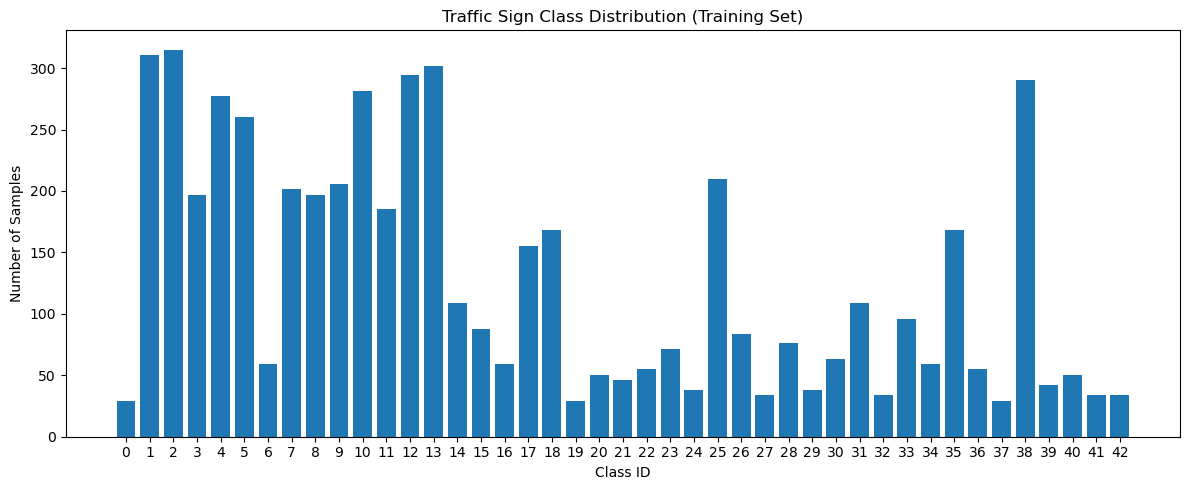

In [7]:
# Compute counts per class
class_counts = train_meta['ClassId'].value_counts().sort_index()

# Plot the class distribution
plt.figure(figsize=(12, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Traffic Sign Class Distribution (Training Set)')
plt.xticks(class_counts.index)
plt.tight_layout()
plt.show()

## 1.3 Summary statistics & missing values

In [8]:
train_meta.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,5488.0,NaN,NaN,NaN,3909.515124,2263.069618,1.0,1954.75,3917.5,5867.5,7840.0
image_path,5488,5488,img_000001.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClassId,5488.0,NaN,NaN,NaN,15.79519,12.018043,0.0,5.0,12.0,25.0,42.0


In [9]:
train_color_hist.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ch_0,5488.0,0.001594,0.017190,0.0,0.000000,0.000000,0.000000,0.630910
ch_1,5488.0,0.091166,0.222423,0.0,0.000000,0.000681,0.027122,0.993316
ch_2,5488.0,0.233191,0.300232,0.0,0.000701,0.060961,0.405630,0.993788
ch_3,5488.0,0.261800,0.257555,0.0,0.030304,0.190260,0.423200,0.995194
ch_4,5488.0,0.248081,0.222946,0.0,0.074960,0.186151,0.366910,0.983005
...,...,...,...,...,...,...,...,...
ch_91,5488.0,0.027486,0.051251,0.0,0.000000,0.000684,0.037093,0.680434
ch_92,5488.0,0.027551,0.052588,0.0,0.000000,0.000000,0.036337,0.855979
ch_93,5488.0,0.029024,0.052812,0.0,0.000000,0.000000,0.038927,0.670786
ch_94,5488.0,0.033417,0.059633,0.0,0.000000,0.000000,0.043190,0.592011


In [10]:
train_hog_pca.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hog_pca_0,5488.0,-3.923591e-07,1.792857,-3.002755,-1.413812,-0.513509,1.095520,3.717479
hog_pca_1,5488.0,-1.945055e-07,1.102799,-2.035571,-0.778555,-0.217388,0.532019,3.969204
hog_pca_2,5488.0,-4.774052e-10,0.941575,-2.898584,-0.524281,0.076371,0.658103,2.211293
hog_pca_3,5488.0,-1.054389e-07,0.735296,-2.611643,-0.363004,0.140469,0.528592,1.596566
hog_pca_4,5488.0,1.137846e-08,0.660458,-2.547139,-0.413524,-0.016157,0.411174,2.784895
hog_pca_5,5488.0,-1.167272e-08,0.611022,-2.806964,-0.347541,-0.006252,0.368248,2.328371
hog_pca_6,5488.0,6.706523e-08,0.603981,-2.588593,-0.381408,0.049212,0.420224,1.656473
hog_pca_7,5488.0,-2.940725e-08,0.533914,-1.536326,-0.352985,-0.049261,0.274383,2.234568
hog_pca_8,5488.0,-3.252453e-07,0.531018,-1.453247,-0.367678,-0.054622,0.303435,2.275320
hog_pca_9,5488.0,5.123980e-08,0.519399,-1.993925,-0.323442,-0.007991,0.340582,1.664894


In [11]:
train_add_feat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
edge_density,5488.0,0.091678,0.072312,0.000000,0.026611,0.084961,0.144348,0.317383
mean_b,5488.0,82.192781,47.171930,9.413818,44.187073,73.654541,112.702942,250.570068
mean_g,5488.0,80.003171,47.214124,7.042725,42.009399,72.266724,111.279907,244.010010
mean_r,5488.0,87.452502,51.082152,8.326660,46.136902,80.216187,120.723755,251.132568


### Check null value

In [12]:
train_meta.isnull().sum()

id            0
image_path    0
ClassId       0
dtype: int64

In [13]:
train_color_hist.isnull().sum().sum()

0

In [14]:
train_hog_pca.isnull().sum()

image_path    0
hog_pca_0     0
hog_pca_1     0
hog_pca_2     0
hog_pca_3     0
hog_pca_4     0
hog_pca_5     0
hog_pca_6     0
hog_pca_7     0
hog_pca_8     0
hog_pca_9     0
hog_pca_10    0
hog_pca_11    0
hog_pca_12    0
hog_pca_13    0
hog_pca_14    0
hog_pca_15    0
hog_pca_16    0
hog_pca_17    0
hog_pca_18    0
hog_pca_19    0
dtype: int64

In [15]:
train_add_feat.isnull().sum()

image_path      0
edge_density    0
mean_b          0
mean_g          0
mean_r          0
dtype: int64

In [16]:
def zero_variance_columns(df):
    return [col for col in df.columns if df[col].nunique() <= 1]

print("Zero-variance columns (train_metadata):", zero_variance_columns(train_meta))
print("Zero-variance columns (color_histogram):", zero_variance_columns(train_color_hist))
print("Zero-variance columns (hog_pca):", zero_variance_columns(train_hog_pca))
print("Zero-variance columns (additional_features):", zero_variance_columns(train_add_feat))

Zero-variance columns (train_metadata): []
Zero-variance columns (color_histogram): []
Zero-variance columns (hog_pca): []
Zero-variance columns (additional_features): []


## 1.4 Feature distributions and outliers

In [17]:
def plot_feature_distributions_and_outliers(df, title, n_features=5):
    """
    For the first n_features numeric columns in df:
      - Plot a histogram (with density=True for a rough density estimate)
      - Then plot a combined boxplot for those features
    """
    numeric = df.select_dtypes(include=['number'])
    cols = numeric.columns[:n_features]

    # Histograms with density
    for col in cols:
        plt.figure()
        plt.hist(numeric[col], bins=40, density=True)
        plt.title(f"{title} — Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.tight_layout()
        plt.show()

    # Combined boxplot for outlier detection
    plt.figure()
    plt.boxplot(numeric[cols].values, vert=True)
    plt.xticks(np.arange(1, len(cols) + 1), cols, rotation=45)
    plt.title(f"{title} — Boxplot")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

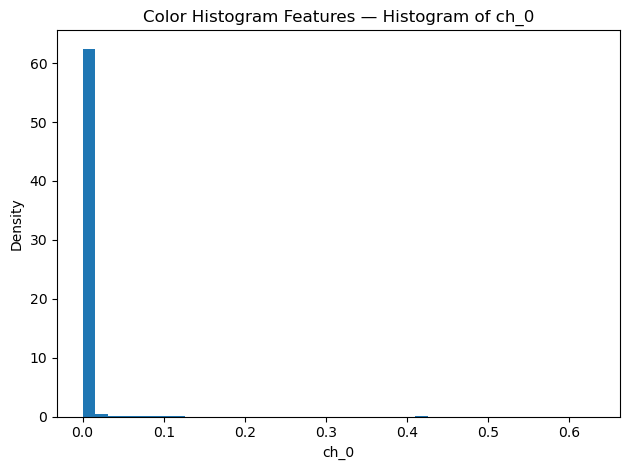

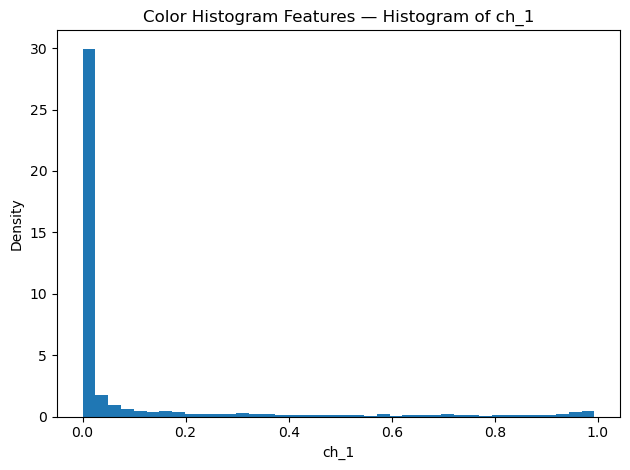

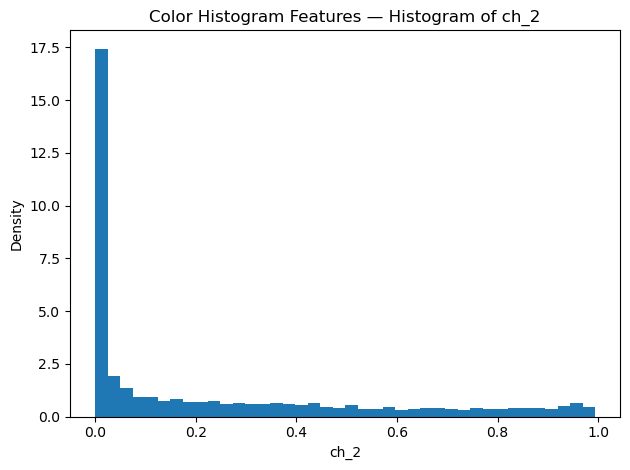

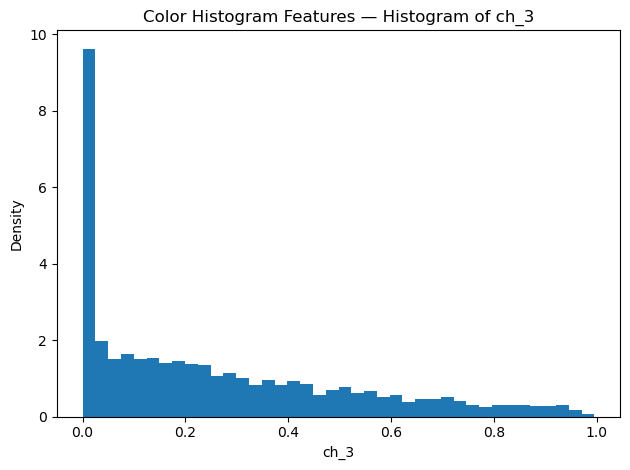

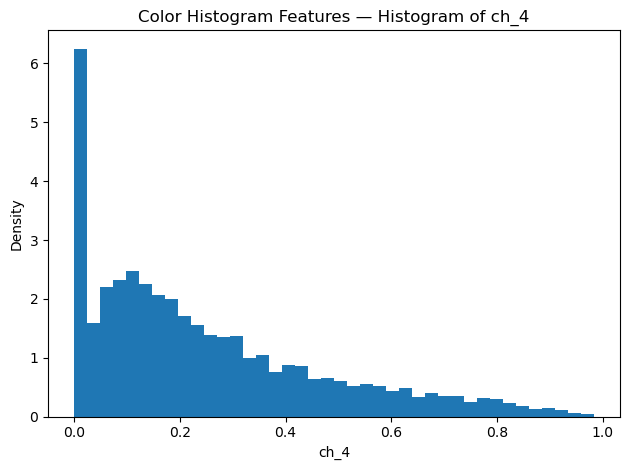

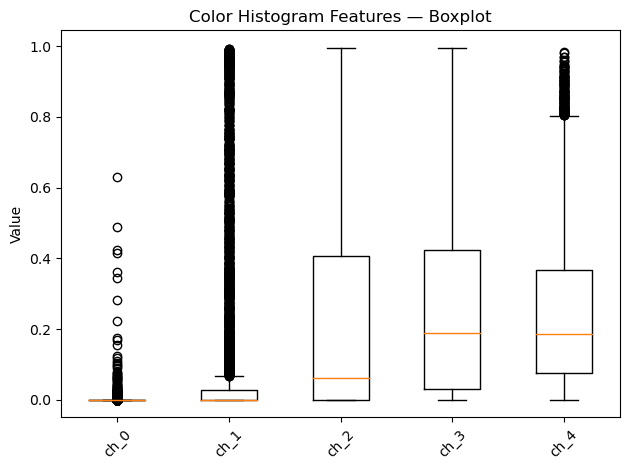

In [18]:
# Plot for each feature set
plot_feature_distributions_and_outliers(train_color_hist, "Color Histogram Features")

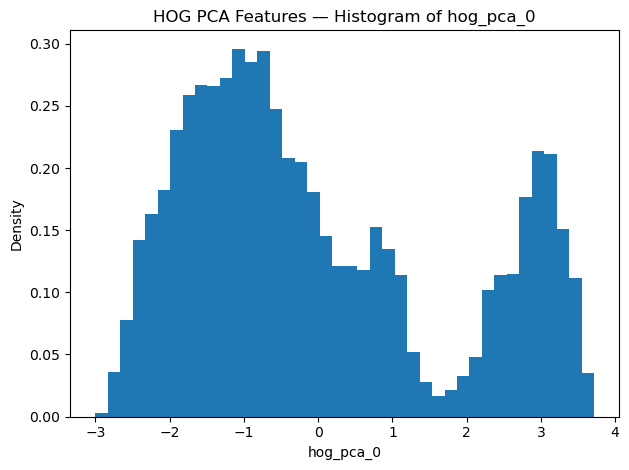

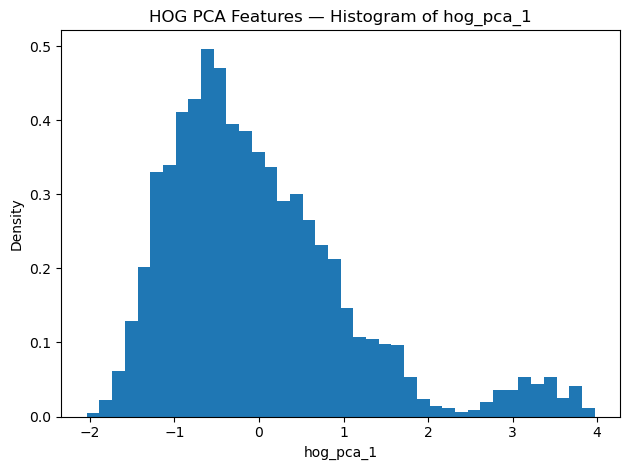

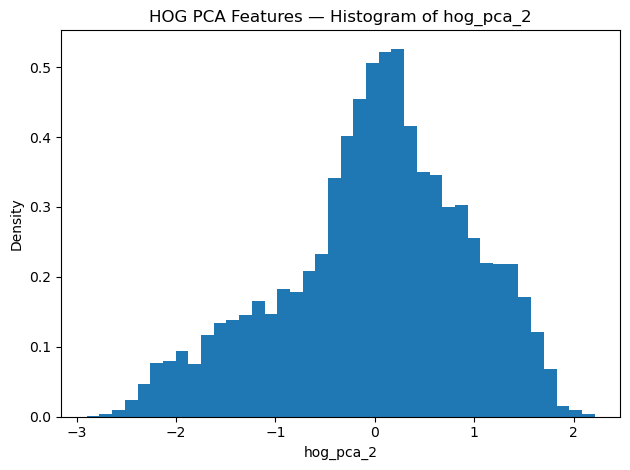

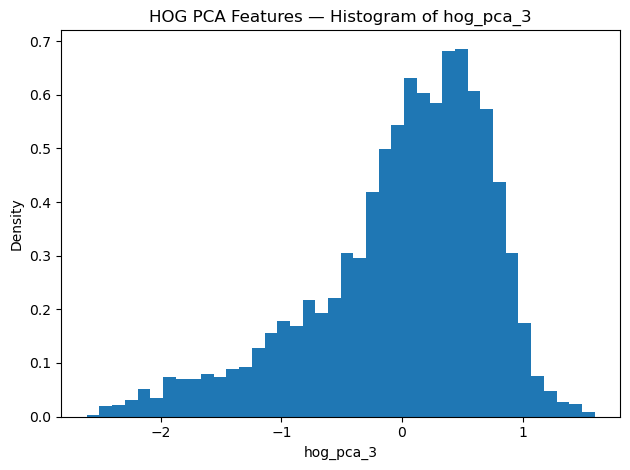

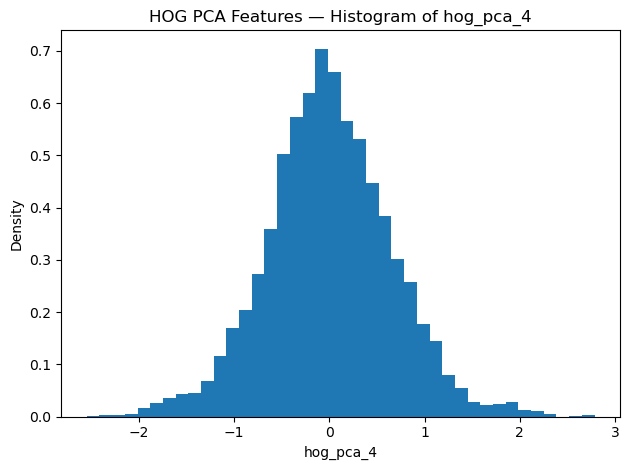

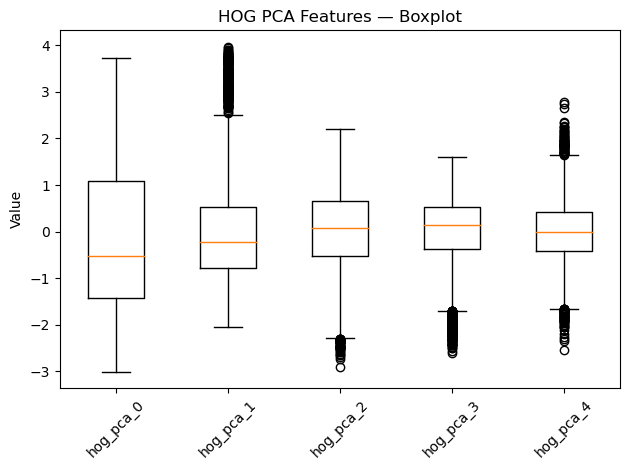

In [19]:
plot_feature_distributions_and_outliers(train_hog_pca, "HOG PCA Features")

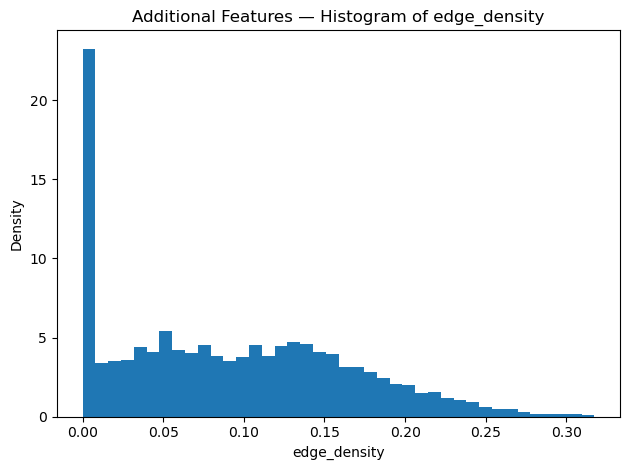

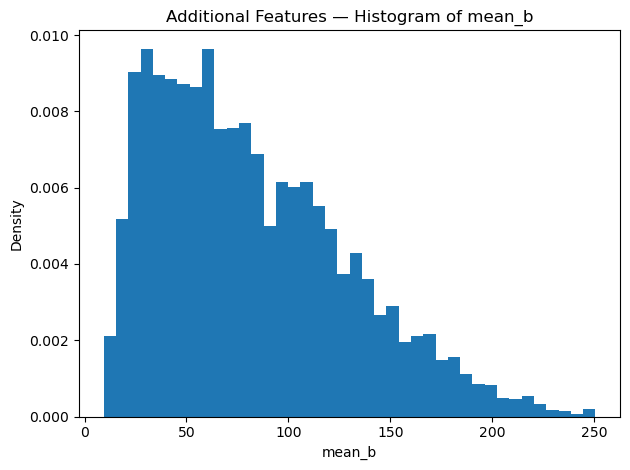

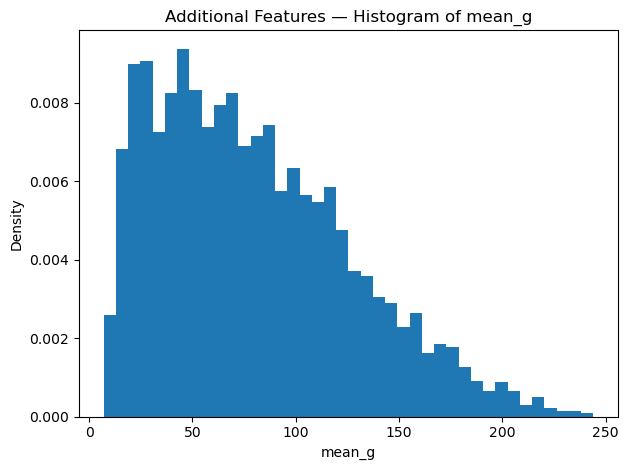

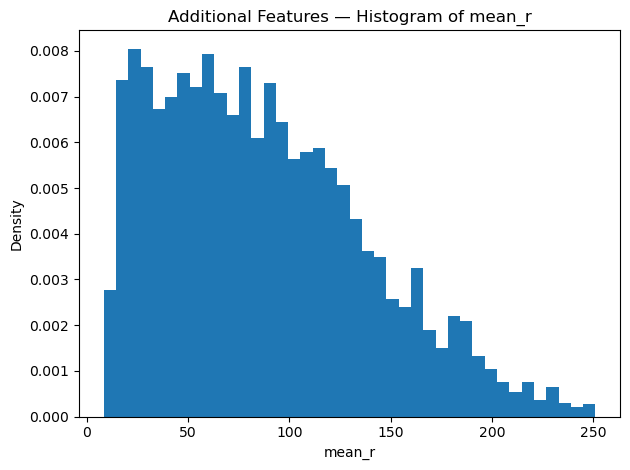

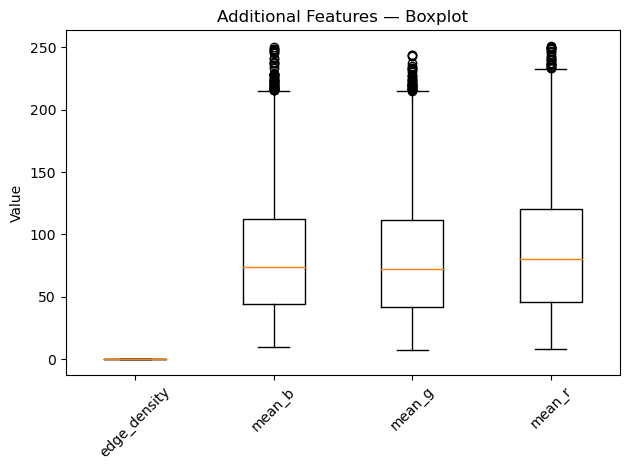

In [20]:
plot_feature_distributions_and_outliers(train_add_feat, "Additional Features")

## 1.5 Correlation analysis

In [21]:
dfs = [train_meta, train_color_hist, train_hog_pca, train_add_feat]
train_all = pd.concat(dfs, axis=1)
train_all = train_all.loc[:, ~train_all.columns.duplicated(keep='first')]
cols = [c for c in train_all.columns if c != 'ClassId'] + ['ClassId']
train_all = train_all[cols]

In [22]:
corr_matrix = train_all.select_dtypes(include=['number']).corr()

In [23]:
corr_matrix

,id,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,ch_8,...,hog_pca_15,hog_pca_16,hog_pca_17,hog_pca_18,hog_pca_19,edge_density,mean_b,mean_g,mean_r,ClassId
id,1.000000,0.012501,0.006717,-0.014143,-0.010584,-0.016514,-0.008205,-0.010694,-0.001917,0.013021,...,0.002011,0.004650,0.020000,0.004089,0.007445,0.004292,0.005436,0.009213,0.011527,-0.003745
ch_0,0.012501,1.000000,0.203884,0.035032,-0.034078,-0.058574,-0.065512,-0.063272,-0.062237,-0.057378,...,-0.062259,-0.015270,-0.023538,-0.031468,0.016600,-0.040298,-0.075763,-0.069525,-0.066030,-0.010005
ch_1,0.006717,0.203884,1.000000,0.311950,-0.069170,-0.190743,-0.238065,-0.255601,-0.266047,-0.275572,...,-0.196061,-0.069365,-0.058188,-0.074660,0.066034,-0.329266,-0.419908,-0.426147,-0.426044,-0.044364
ch_2,-0.014143,0.035032,0.311950,1.000000,0.322148,-0.117325,-0.252141,-0.314281,-0.320136,-0.342279,...,-0.131795,-0.104952,-0.046665,-0.006797,0.079850,-0.364901,-0.548566,-0.550191,-0.537327,-0.117536
ch_3,-0.010584,-0.034078,-0.069170,0.322148,1.000000,0.386529,-0.029163,-0.172239,-0.212299,-0.246170,...,-0.019976,-0.066809,0.012387,0.045739,0.043040,-0.205382,-0.456930,-0.444294,-0.415479,-0.123589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
edge_density,0.004292,-0.040298,-0.329266,-0.364901,-0.205382,-0.048815,0.044018,0.105352,0.178877,0.236201,...,0.081416,0.117396,-0.053589,0.064179,-0.082859,1.000000,0.626191,0.667719,0.702699,0.006111
mean_b,0.005436,-0.075763,-0.419908,-0.548566,-0.456930,-0.314263,-0.170590,-0.049497,0.047224,0.133611,...,0.164464,0.146688,0.006232,-0.009011,-0.111885,0.626191,1.000000,0.976053,0.920952,0.146832
mean_g,0.009213,-0.069525,-0.426147,-0.550191,-0.444294,-0.289885,-0.141981,-0.022196,0.073260,0.156719,...,0.163144,0.141610,-0.005041,-0.000859,-0.101500,0.667719,0.976053,1.000000,0.976284,0.072080
mean_r,0.011527,-0.066030,-0.426044,-0.537327,-0.415479,-0.248741,-0.097413,0.017511,0.107134,0.183580,...,0.159998,0.135435,-0.024004,0.018835,-0.083967,0.702699,0.920952,0.976284,1.000000,-0.011273


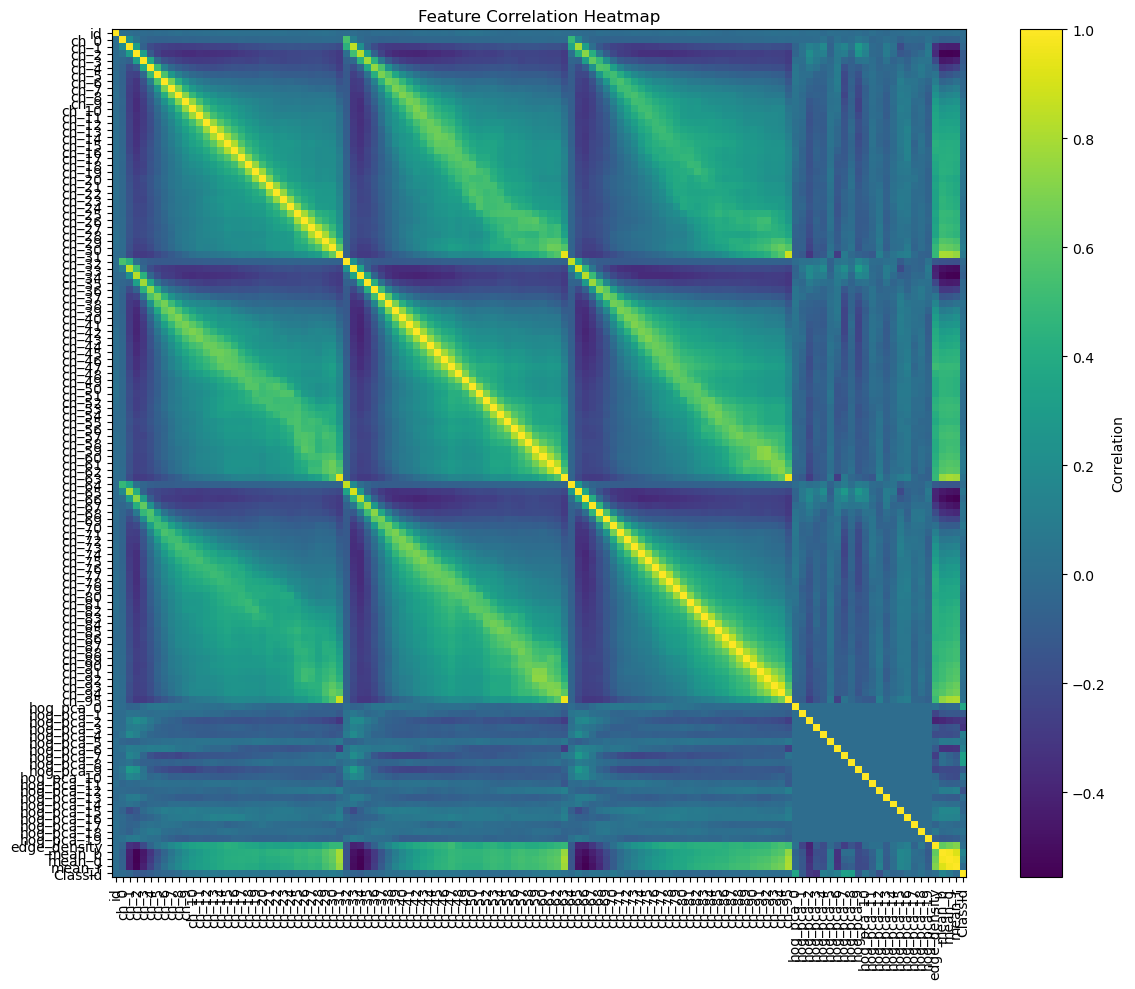

In [24]:
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, aspect='auto', interpolation='none')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [25]:
# Extract highly correlated feature pairs 
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_pairs = (
    corr_matrix.where(mask)
    .stack()
    .reset_index()
    .rename(columns={'level_0':'feature_1','level_1':'feature_2',0:'correlation'})
)
high_corr = corr_pairs[np.abs(corr_pairs['correlation']) > 0.9] \
            .sort_values(by='correlation', key=lambda x: np.abs(x), ascending=False)

print("Top highly correlated feature pairs (|corr| > 0.9):")
print(high_corr.head(10).to_string(index=False))

Top highly correlated feature pairs (|corr| > 0.9):
feature_1 feature_2  correlation
   mean_g    mean_r     0.976284
   mean_b    mean_g     0.976053
    ch_63     ch_95     0.960023
    ch_31     ch_63     0.940705
   mean_b    mean_r     0.920952
    ch_33     ch_65     0.904409


Explained variance ratios for color-histogram PCA (10 components):
  PC1: 0.2699
  PC2: 0.1767
  PC3: 0.1110
  PC4: 0.0712
  PC5: 0.0504
  PC6: 0.0334
  PC7: 0.0237
  PC8: 0.0182
  PC9: 0.0166
  PC10: 0.0160


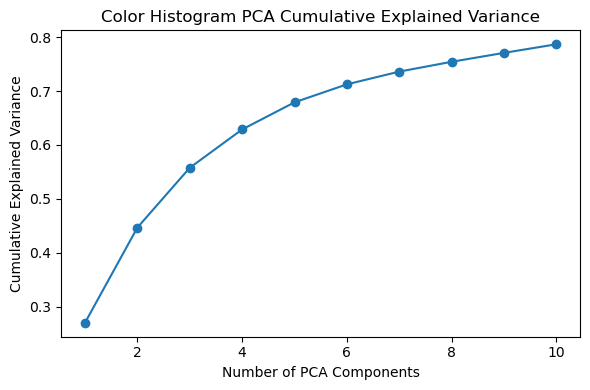

In [26]:
# Inspect explained variance for the 10 color-histogram PCA
color_cols = [c for c in train_all.columns if c.startswith('ch_')]
pca_color = PCA(n_components=10, random_state=18)
pca_color.fit(train_all[color_cols])
evr = pca_color.explained_variance_ratio_

print("Explained variance ratios for color-histogram PCA (10 components):")
for i, ratio in enumerate(evr, start=1):
    print(f"  PC{i}: {ratio:.4f}")
    
cumulative = evr.cumsum()
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(evr) + 1), cumulative, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Color Histogram PCA Cumulative Explained Variance')
plt.tight_layout()
plt.show()


# 2. Extract engineered features

In [5]:
def extract_lbp(image, P=8, R=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=bins, range=(0, bins), density=True)
    return hist

def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    m = cv2.moments(gray)
    hu = cv2.HuMoments(m).flatten()
    return -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)

In [6]:
def build_image_features(metadata_df, img_root):
    # Pick a dummy image to measure each extractor’s output length
    first_path = os.path.join(img_root, metadata_df.iloc[0]['image_path'])
    dummy = cv2.imread(first_path)
    lengths = {
        'lbp':    len(extract_lbp(dummy)),
        'hu':     len(extract_hu_moments(dummy)),
    }
    
    # Build column names 
    col_names = []
    for name, length in lengths.items():
        col_names += [f"{name}_{i}" for i in range(length)]

    # Extract features for every image
    feats = []
    for _, row in metadata_df.iterrows():
        img_path = os.path.join(img_root, row['image_path'])
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {img_path}")
        all_feats = np.hstack([
            extract_lbp(img),
            extract_hu_moments(img),
        ])
        feats.append(all_feats)

    # Stack into array 
    feats_arr = np.vstack(feats)
    assert feats_arr.shape[1] == len(col_names), (
        f"Mismatch: data has {feats_arr.shape[1]} cols but {len(col_names)} names"
    )

    # Build DataFrame
    feat_df = pd.DataFrame(feats_arr, columns=col_names, index=metadata_df.index)
    return feat_df


## Extract 10 lbp features and 7 hu features (just run this cell once)

In [7]:
#for training set
train_meta = pd.read_csv("2025_A2/train/train_metadata.csv")
train_img_feats = build_image_features(train_meta, img_root="2025_A2/train")

#for test set
test_meta = pd.read_csv("2025_A2/test/test_metadata.csv")
test_img_feats  = build_image_features(test_meta, img_root="2025_A2/test")
train_feats = pd.concat(
    [train_meta[['id', 'image_path']].reset_index(drop=True),
     train_img_feats.reset_index(drop=True)],
    axis=1
)
test_feats = pd.concat(
    [test_meta[['id', 'image_path']].reset_index(drop=True),
     test_img_feats.reset_index(drop=True)],
    axis=1
)
train_feats.to_csv('engineered_feats/train_img_feats.csv', index=False)
test_feats.to_csv('engineered_feats/test_img_feats.csv', index=False)

# 3. Implement learning models

In [8]:
def load_data(opt, eng = False):
    # Read core tables
    data_meta       = pd.read_csv(f"2025_A2/{opt}/{opt}_metadata.csv")
    data_color_hist = pd.read_csv(f"2025_A2/{opt}/Features/color_histogram.csv")
    data_hog_pca    = pd.read_csv(f"2025_A2/{opt}/Features/hog_pca.csv")
    data_add_feat   = pd.read_csv(f"2025_A2/{opt}/Features/additional_features.csv")
    
    # Build list of DataFrames to concat
    dfs = [data_meta, data_color_hist, data_hog_pca, data_add_feat]
    
    # Optionally include engineered image features
    if eng:
        data_img_feats = pd.read_csv(f"engineered_feats/{opt}_img_feats.csv")
        dfs.append(data_img_feats)
    
    # Concatenate and drop duplicated columns
    data_all = pd.concat(dfs, axis=1)
    data_all = data_all.loc[:, ~data_all.columns.duplicated(keep='first')]
    
    # Move 'ClassId' to the end
    if 'ClassId' in data_all.columns:
        cols = [c for c in data_all.columns if c != 'ClassId'] + ['ClassId']
        data_all = data_all[cols]
    
    return data_all

_color_pca = None
def preprocess_df(df):
    global _color_pca
    
    df_proc = df.copy()
    
    # PCA on color histogram columns
    ch_cols = [c for c in df_proc.columns if c.startswith('ch_')]
    if _color_pca is None:
        _color_pca = PCA(n_components=10, random_state=18)
        ch_transformed = _color_pca.fit_transform(df_proc[ch_cols])
    else:
        ch_transformed = _color_pca.transform(df_proc[ch_cols])
    pca_cols = [f'ch_pca_{i}' for i in range(ch_transformed.shape[1])]
    
    # Drop original ch, add pca_ch
    df_proc = df_proc.drop(columns=ch_cols)
    for i, col in enumerate(pca_cols):
        df_proc[col] = ch_transformed[:, i]
    
    # Remove brightness from mean RGB
    rgb_cols = ['mean_r', 'mean_g', 'mean_b']
    if all(c in df_proc.columns for c in rgb_cols):
        rgb_sum = df_proc[rgb_cols].sum(axis=1).replace(0, 1)
        df_proc['r_chroma'] = df_proc['mean_r'] / rgb_sum
        df_proc['g_chroma'] = df_proc['mean_g'] / rgb_sum
        df_proc['b_chroma'] = df_proc['mean_b'] / rgb_sum
        df_proc = df_proc.drop(columns=rgb_cols)
    
    # Log-transform edge_density
    if 'edge_density' in df_proc.columns:
        df_proc['edge_density'] = np.log1p(df_proc['edge_density'])
    
    # Move ClassId to last
    if 'ClassId' in df_proc.columns:
        cols = [c for c in df_proc.columns if c != 'ClassId'] + ['ClassId']
        df_proc = df_proc[cols]
    return df_proc

def train_val_split(data):
    X = data.drop(columns=['id','image_path','ClassId'])
    y = data['ClassId']
    # Stratified, with 20% validation
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state= 40 , stratify=y
    )
    return X_train, X_val, y_train, y_val

def prepare_train_test(train_data, test_data):
    X_train = train_data.drop(columns=['id','image_path','ClassId'])
    y_train = train_data['ClassId']
    X_test = test_data.drop(columns=['id','image_path','ClassId'])
    return X_train, X_test, y_train

def generate_submission(path, x_id, y_pred):
    # Create dataframe
    submission = pd.DataFrame({
        'id': x_id,
        'ClassId': y_pred
    })
    
    # Save to CSV
    submission.to_csv(path, index=False, header = True)

    # Show sample
    print("First 5 rows of the submission:")
    print(submission.head())

# 3.1 Load data

In [9]:
train_meta = pd.read_csv("2025_A2/train/train_metadata.csv")
test_meta = pd.read_csv("2025_A2/test/test_metadata.csv")

## 3.1.1 Load data with provided features

In [10]:
train_all_raw = load_data("train")
test_all_raw = load_data("test")
test_id = test_all_raw['id']

In [11]:
train_all_raw

,id,image_path,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,...,hog_pca_15,hog_pca_16,hog_pca_17,hog_pca_18,hog_pca_19,edge_density,mean_b,mean_g,mean_r,ClassId
0,7218,img_000001.jpg,0.000000,0.000000,0.268901,0.355617,0.511548,0.264923,0.526664,0.321408,...,0.450825,-0.213796,-0.882416,-0.309656,0.271686,0.050293,63.748291,62.107910,62.850830,32
1,6333,img_000002.jpg,0.000000,0.002267,0.657901,0.641467,0.222700,0.243100,0.108233,0.036833,...,-0.335682,-0.886182,0.507969,0.006536,0.471807,0.034424,48.680664,52.872314,61.539307,13
2,6867,img_000003.jpg,0.002243,0.143541,0.385766,0.091956,0.066163,0.204097,0.353245,0.218676,...,0.501386,-0.421448,0.081289,0.730258,-0.205895,0.126709,99.174561,110.774658,127.348389,7
3,7730,img_000004.jpg,0.000000,0.096069,0.947646,0.217350,0.160404,0.083028,0.042601,0.045209,...,0.285638,-0.481589,-0.101580,-0.139084,0.586276,0.026123,30.493896,26.616211,29.006592,4
4,6338,img_000005.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.015324,0.029918,0.024810,...,-0.520063,0.062209,0.248771,0.140214,0.292198,0.106934,116.836670,97.684814,79.495605,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,456,img_005484.jpg,0.000000,0.005113,0.063918,0.241182,0.466172,0.542874,0.327258,0.088632,...,-0.141590,0.172979,-0.356541,-0.167192,-0.452964,0.100586,97.798096,107.457275,139.611816,17
5484,4084,img_005485.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.294122,-0.072038,0.171852,-0.131252,0.146278,0.034180,171.357422,156.866699,163.271484,4
5485,5117,img_005486.jpg,0.005808,0.045637,0.260545,0.253077,0.143549,0.107039,0.080487,0.072189,...,-0.542944,0.056787,-0.252209,-0.082190,-0.157411,0.247559,144.043701,158.237793,180.798340,2
5486,3334,img_005487.jpg,0.000000,0.504522,0.417509,0.373240,0.436591,0.116780,0.052666,0.032057,...,0.211036,-0.284097,0.555815,-1.190879,0.073978,0.038818,89.712158,84.372314,83.712646,3


In [12]:
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_val_split(train_all_raw)
X_full_raw, X_test_raw, y_full_raw = prepare_train_test(train_all_raw, test_all_raw)

## 3.1.2 Load and preprocess data with additional engineered features

In [13]:
train_all = load_data("train", True)
test_all = load_data("test", True)
train_preprocessed = preprocess_df(train_all)
test_preprocessed = preprocess_df(test_all)
test_id = test_all['id']

In [14]:
X_train, X_val, y_train, y_val = train_val_split(train_preprocessed)
X_full, X_test, y_full = prepare_train_test(train_preprocessed, test_preprocessed)

# 3.2 Classical baseline models

In [60]:
# 1) Define baseline models: 6 models
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000, solver='lbfgs', multi_class='auto',
        class_weight='balanced', random_state=18
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, class_weight='balanced', random_state=18
    ),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF kernel)': SVC(
        kernel='rbf', class_weight='balanced',
        gamma='scale', probability=False, random_state=18
    ),
    'Gaussian NB': GaussianNB(),
    'MLP (100 hidden units)': MLPClassifier(
        hidden_layer_sizes=(100,), max_iter=1000,
        learning_rate_init=1e-3, random_state=18
    )
}

## 3.2.1 With provided data

In [43]:
X_train_raw_np = np.ascontiguousarray(X_train_raw.to_numpy(dtype=float))
y_train_raw_np = np.ascontiguousarray(y_train_raw.to_numpy(dtype=int))
X_val_raw_np   = np.ascontiguousarray(X_val_raw.to_numpy(dtype=float))
y_val_raw_np   = np.ascontiguousarray(y_val_raw.to_numpy(dtype=int))

# Fit and predict
results = []
for name, model in models.items():
    model.fit(X_train_raw_np, y_train_raw_np)
    y_pred = model.predict(X_val_raw_np)
    acc = accuracy_score(y_val_raw_np, y_pred)
    f1  = f1_score(y_val_np, y_pred, average='macro')
    results.append({'Model': name, 'Accuracy': acc, 'Macro F1': f1})
    
# Display results
results_df = pd.DataFrame(results).set_index('Model')
print(results_df)

C:\Users\trong\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                        Accuracy  Macro F1
Model                                     
Logistic Regression     0.814208  0.800439
Random Forest           0.775046  0.759802
k-NN (k=5)              0.343352  0.297461
SVM (RBF kernel)        0.040073  0.024042
Gaussian NB             0.225865  0.236243
MLP (100 hidden units)  0.818761  0.794261


## 3.2.2 With extracted engineered preprocessed features

In [39]:
X_train_np = np.ascontiguousarray(X_train.to_numpy(dtype=float))
y_train_np = np.ascontiguousarray(y_train.to_numpy(dtype=int))
X_val_np   = np.ascontiguousarray(X_val.to_numpy(dtype=float))
y_val_np   = np.ascontiguousarray(y_val.to_numpy(dtype=int))

# Fit and predict
results = []
for name, model in models.items():
    model.fit(X_train_np, y_train_np)
    y_pred = model.predict(X_val_np)
    acc = accuracy_score(y_val_np, y_pred)
    f1  = f1_score(y_val_np, y_pred, average='macro')
    results.append({'Model': name, 'Accuracy': acc, 'Macro F1': f1})
    
# Display results
results_df = pd.DataFrame(results).set_index('Model')
print(results_df)

C:\Users\trong\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                        Accuracy  Macro F1
Model                                     
Logistic Regression     0.781421  0.766727
Random Forest           0.780510  0.748588
k-NN (k=5)              0.537341  0.464084
SVM (RBF kernel)        0.200364  0.139245
Gaussian NB             0.581967  0.575645
MLP (100 hidden units)  0.775046  0.755813


# 3.3 Classical models

## 3.3.1 Random forest

In [14]:
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('rf',    RandomForestClassifier(class_weight='balanced', random_state=18))
])

param_grid = {
    'rf__n_estimators':      [500, 1000],
    'rf__max_depth':         [None, 30],
    'rf__min_samples_split': [2, 5],           
    'rf__max_features':      ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    error_score='raise' 
)

# Fit
grid_rf.fit(X_train, y_train)

best_params_rf    = grid_rf.best_params_
best_cv_score_rf  = grid_rf.best_score_
best_rf           = grid_rf.best_estimator_

# Predict on validation set
y_val_pred = best_rf.predict(X_val)
val_acc    = accuracy_score(y_val, y_val_pred)
val_f1     = f1_score(y_val, y_val_pred, average='macro')

# Print metrics
print("Best RF params:", best_params_rf)
print(f"Validation — Accuracy: {val_acc:.4f}, Macro F1: {val_f1:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best RF params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 5, 'rf__n_estimators': 500}
Validation — Accuracy: 0.8115, Macro F1: 0.7820


In [18]:
print(f'Accuracy: {val_acc}, F1: {val_f1}')

Accuracy: 0.8114754098360656, F1: 0.7819598215207835


### Final random forest model

In [15]:
# Build the RF pipeline with known best parameters
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('rf',    RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features='sqrt',
        min_samples_split=5,
        class_weight='balanced',
        random_state=18,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

# Run cross-validation
cv_results = cross_validate(
    pipe_rf,
    X_full,
    y_full,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    n_jobs=-1,
    return_train_score=False
)

# Report mean scores
mean_acc = cv_results['test_accuracy'].mean()
mean_f1  = cv_results['test_f1_macro'].mean()
print(f"Mean accuracy:   {mean_acc:.4f}")
print(f"Mean macro F1:   {mean_f1:.4f}")

Mean accuracy:   0.8169
Mean macro F1:   0.8066


### On raw dataset

In [60]:
pipe_rf = Pipeline([
    ('scale', StandardScaler()),
    ('rf',    RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features='sqrt',
        min_samples_split=5,
        class_weight='balanced',
        random_state=18,
        n_jobs=-1
    ))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

cv_results = cross_validate(
    pipe_rf,
    X_full_raw,
    y_full_raw,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    n_jobs=-1,
    return_train_score=False
)

# Report mean scores
mean_acc = cv_results['test_accuracy'].mean()
mean_f1  = cv_results['test_f1_macro'].mean()
print(f"Mean accuracy:   {mean_acc:.4f}")
print(f"Mean macro F1:   {mean_f1:.4f}")

Mean accuracy:   0.8109
Mean macro F1:   0.8065


### Predict test labels

In [16]:
best_rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        max_features='sqrt',
        min_samples_split=5,
        class_weight='balanced',
        random_state=18,
        n_jobs=-1
)

In [18]:
best_rf.fit(X_full, y_full)
y_test_pred = best_rf.predict(X_test)
generate_submission("rf.csv", test_id, y_test_pred)

First 5 rows of the submission:
     id  ClassId
0   661       12
1  4477        9
2  1046        8
3   631        4
4  6533        3


# 3.3.2 Multi layers processing (MLP)

In [29]:
# Build pipeline
pipe_mlp = Pipeline([
    ('scale',  StandardScaler()),
    ('select', SelectKBest(f_classif)),  
    ('mlp',    MLPClassifier(max_iter=500, early_stopping=True, random_state=18))
])

# Define hyperparameter grid
param_grid = {
    'select__k':                [20, 30, 50],
    'mlp__hidden_layer_sizes':  [(50,), (100,), (100, 50)],
    'mlp__alpha':               [1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init':  [1e-4, 1e-3],
    'mlp__activation':          ['relu', 'tanh']
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

# Grid search setup
grid_mlp = GridSearchCV(
    pipe_mlp,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit on training split
grid_mlp.fit(X_train, y_train)

# Capture best model and CV score
best_params_mlp    = grid_mlp.best_params_
best_cv_score_mlp  = grid_mlp.best_score_
best_mlp_model     = grid_mlp.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


### Final MLP model

In [55]:
pipe_mlp = Pipeline([
    ('scale', StandardScaler()),
    ('mlp',   MLPClassifier(
        hidden_layer_sizes=(100, 50),
        alpha=0.01,
        learning_rate_init=1e-3,
        activation='relu',
        max_iter=500,
        early_stopping=True,
        random_state=18
    ))
])

# Define stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Run cross-validation for accuracy and macro F1
cv_results = cross_validate(
    pipe_mlp,
    X_full,
    y_full,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    n_jobs=-1,
    return_train_score=False
)
print(f"Mean accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean macro F1: {cv_results['test_f1_macro'].mean():.4f}")

Mean accuracy: 0.8400
Mean macro F1: 0.8265


In [67]:
pipe_mlp.fit(X_train, y_train)
y_val_pred = pipe_mlp.predict(X_val)

# Report metrics
print("Validation Accuracy :", accuracy_score(y_val, y_val_pred))
print("Validation Macro F1  :", f1_score(y_val, y_val_pred, average='macro'))

Validation Accuracy : 0.8333333333333334
Validation Macro F1  : 0.8033116542150087


### On raw datasets

In [54]:
pipe_mlp = Pipeline([
    ('scale', StandardScaler()),
    ('mlp',   MLPClassifier(
        hidden_layer_sizes=(100, 50),
        alpha=0.01,
        learning_rate_init=1e-3,
        activation='relu',
        max_iter=500,
        early_stopping=True,
        random_state=18
    ))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Run cross-validation for accuracy and macro F1
cv_results = cross_validate(
    pipe_mlp,
    X_full_raw,
    y_full_raw,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    n_jobs=-1,
    return_train_score=False
)
print(f"Mean accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean macro F1: {cv_results['test_f1_macro'].mean():.4f}")

Mean accuracy: 0.8045
Mean macro F1: 0.7844


### Predict test labels

In [22]:
pipe_mlp = Pipeline([
    ('scale', StandardScaler()),
    ('mlp',   MLPClassifier(
        hidden_layer_sizes=(100, 50),
        alpha=0.01,
        learning_rate_init=1e-3,
        activation='relu',
        max_iter=500,
        early_stopping=True,
        random_state=18
    ))
])

pipe_mlp.fit(X_full, y_full)
y_test_pred = pipe_mlp.predict(X_test)
generate_submission("mlp.csv", test_id, y_test_pred)

First 5 rows of the submission:
     id  ClassId
0   661       12
1  4477       42
2  1046       10
3   631        8
4  6533        1


# 3.4 Stacking on RF, MLP, SVM

## 3.4.1 Build model

In [23]:
# Best performing rf model
rf_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('rf',    RandomForestClassifier(
        n_estimators=500,
        max_depth= None,
        max_features='sqrt',
        min_samples_leaf=5,
        min_samples_split=2,
        class_weight='balanced',
        random_state=18,
        n_jobs=-1
    ))
])

# SVM model
svm_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(f_classif, k=50)), 
    ('svm',   SVC(
        kernel='rbf',
        C=10,          
        gamma='scale',  
        class_weight='balanced',
        probability=True,
        random_state=41
    ))
])

# Best performing mlp model
mlp_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(f_classif, k=30)),
    ('mlp',   MLPClassifier(
        hidden_layer_sizes=(100, 50),
        alpha=0.01,
        learning_rate_init=1e-3,
        activation='relu',
        max_iter=500,
        early_stopping=True,
        random_state=18
    ))
])

# Build the stacking classifier
stack_clf = StackingClassifier(
    estimators=[
        ('rf',  rf_pipe),
        ('svm', svm_pipe),
        ('mlp', mlp_pipe)
    ],
    final_estimator=LogisticRegression(max_iter=3000),
    n_jobs=-1,
    passthrough=True
)

In [25]:
# Best performing rf model
rf_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('rf',    RandomForestClassifier(
        n_estimators=500,
        max_depth= None,
        max_features='sqrt',
        min_samples_leaf=5,
        min_samples_split=2,
        class_weight='balanced',
        random_state=18,
        n_jobs=-1
    ))
])


svm_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(f_classif, k=50)), 
    ('svm',   SVC(
        kernel='rbf',
        C=10,          
        gamma='scale',  
        class_weight='balanced',
        probability=True,
        random_state=41
    ))
])

# Best performing mlp model
mlp_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(f_classif, k=30)),
    ('mlp',   MLPClassifier(
        hidden_layer_sizes=(100, 50),
        alpha=0.01,
        learning_rate_init=1e-3,
        activation='relu',
        max_iter=500,
        early_stopping=True,
        random_state=18
    ))
])

# Build the stacking classifier
stack_clf = StackingClassifier(
    estimators=[
        ('rf',  rf_pipe),
        ('svm', svm_pipe),
        ('mlp', mlp_pipe)
    ],
    final_estimator=LogisticRegression(max_iter=3000),
    n_jobs=-1,
    passthrough=True
)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

# Run cross-validation on the full dataset
cv_results = cross_validate(
    stack_clf,
    X_full,
    y_full,
    cv=cv,
    scoring=['accuracy', 'f1_macro'],
    n_jobs=-1,
    return_train_score=False
)

# Report mean test metrics
mean_acc = cv_results['test_accuracy'].mean()
mean_f1  = cv_results['test_f1_macro'].mean()

print(f"Stacking 5-fold CV Mean Accuracy   : {mean_acc:.4f}")
print(f"Stacking 5-fold CV Mean Macro F1  : {mean_f1:.4f}")

Stacking 5-fold CV Mean Accuracy   : 0.8899
Stacking 5-fold CV Mean Macro F1  : 0.8860


### Predict test labels

In [21]:
stack_clf.fit(X_full, y_full)
y_test_pred = stack_clf.predict(X_test)
print(y_test_pred)

[12  2  2 ... 31 37 12]


In [22]:
generate_submission("first_stack.csv", test_id, y_test_pred)

First 5 rows of the submission:
     id  ClassId
0   661       12
1  4477        2
2  1046        2
3   631        7
4  6533        5


## 3.4.2 Error analysis on stacking

In [26]:
# Get the stacking predictions
stack_clf.fit(X_train, y_train)
y_val_pred = stack_clf.predict(X_val)

# Print a full classification report
print("\t\t\tCLASSIFICATION REPORT:")
print(classification_report(y_val, y_val_pred, digits=4))



			CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0     1.0000    0.6667    0.8000         6
           1     0.7846    0.8226    0.8031        62
           2     0.7581    0.7460    0.7520        63
           3     0.8182    0.6923    0.7500        39
           4     0.7879    0.9455    0.8595        55
           5     0.7551    0.7115    0.7327        52
           6     1.0000    1.0000    1.0000        12
           7     0.7778    0.8750    0.8235        40
           8     0.8966    0.6667    0.7647        39
           9     0.8696    0.9756    0.9195        41
          10     0.9630    0.9286    0.9455        56
          11     0.7500    0.8108    0.7792        37
          12     1.0000    0.9831    0.9915        59
          13     0.9833    0.9833    0.9833        60
          14     0.9130    0.9545    0.9333        22
          15     1.0000    1.0000    1.0000        18
          16     1.0000    0.9167    0.9565        12
 

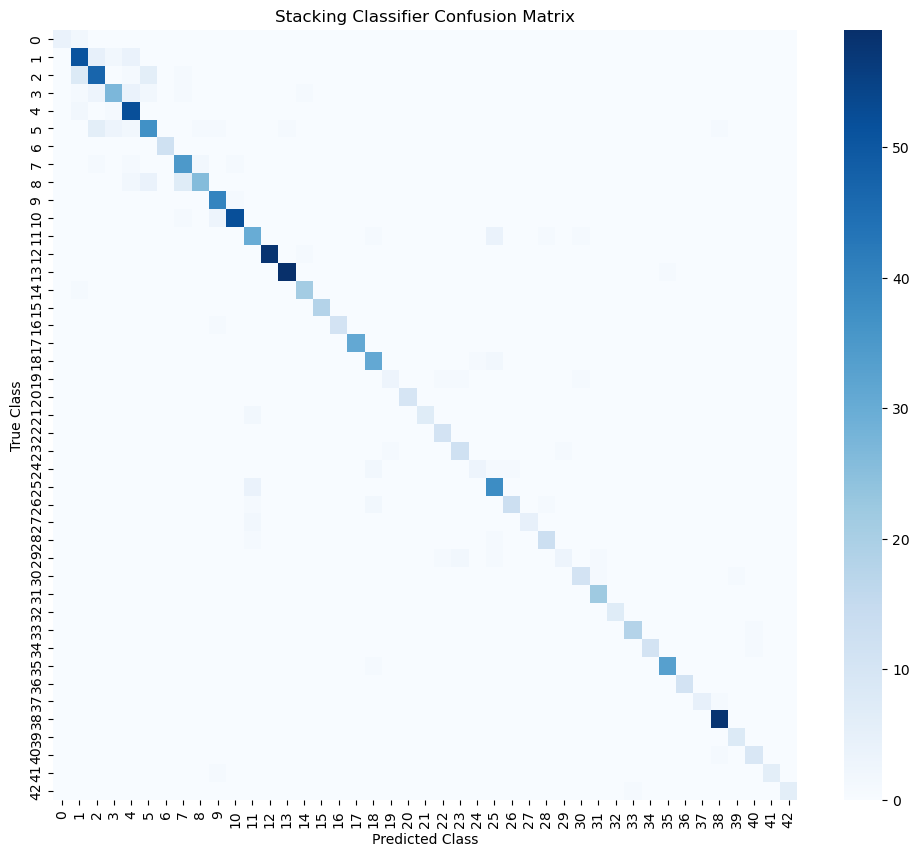

In [27]:
# Plot the confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=sorted(np.unique(y_val)))
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y_val)),
            yticklabels=sorted(np.unique(y_val)))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Stacking Classifier Confusion Matrix")
plt.show()

In [70]:
# Identify the worst‐performing classes (recall < 80%)
report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
low_recall = {cls: stats['recall']
              for cls,stats in report.items() 
              if cls.isdigit() and stats['recall'] < 0.8}
print("Classes with recall < 0.80:")
for cls,rec in sorted(low_recall.items(), key=lambda x: x[1]):
    print(f"  Class {cls}: recall = {rec:.2f}")

Classes with recall < 0.80:
  Class 29: recall = 0.38
  Class 24: recall = 0.43
  Class 19: recall = 0.50
  Class 0: recall = 0.67
  Class 8: recall = 0.67
  Class 3: recall = 0.69
  Class 5: recall = 0.71
  Class 27: recall = 0.71
  Class 2: recall = 0.75
  Class 26: recall = 0.76
  Class 21: recall = 0.78


In [75]:
# Identify the worst‐performing classes (precision < 80%)
report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
low_precision = {cls: stats['precision']
              for cls,stats in report.items() 
              if cls.isdigit() and stats['precision'] < 0.8}
print("Classes with precision < 0.80:")
for cls,rec in sorted(low_precision.items(), key=lambda x: x[1]):
    print(f"  Class {cls}: Precision = {rec:.2f}")

Classes with recall < 0.80:
  Class 11: Precision = 0.75
  Class 19: Precision = 0.75
  Class 24: Precision = 0.75
  Class 29: Precision = 0.75
  Class 5: Precision = 0.76
  Class 2: Precision = 0.76
  Class 7: Precision = 0.78
  Class 1: Precision = 0.78
  Class 4: Precision = 0.79


## 3.4.3 Fine-tune stacking

### 1. Boosting: Increase weight with low-recall labels

In [44]:
# List of low-recall classes 
low_recall = [29, 24, 19, 0, 8, 3, 5, 27, 2, 26, 21]

# Build a class_weight dict that doubles the penalty for those classes:
classes = np.unique(y_train)
cw = {int(c): (2.0 if c in low_recall else 1.0) for c in classes}

# Rebuild the stacking classifier with a class‐weighted final estimator:
stack_clf_weighted = StackingClassifier(
    estimators=[
        ('rf',  rf_pipe),
        ('svm', svm_pipe),
        ('mlp', mlp_pipe)
    ],
    final_estimator=LogisticRegression(
        class_weight=cw,
        solver='lbfgs',
        max_iter=3000
    ),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Fit on the training split
stack_clf_weighted.fit(X_train, y_train)

# Predict & evaluate on validation
y_val_pred = stack_clf_weighted.predict(X_val)
acc = accuracy_score(y_val, y_val_pred)
f1  = f1_score(y_val, y_val_pred, average='macro')

print(f"Class-Weighted Stacking → Val Accuracy: {acc:.4f}")
print(f"Class-Weighted Stacking → Val Macro-F1: {f1:.4f}")

C:\Users\trong\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Class-Weighted Stacking → Val Accuracy: 0.8807
Class-Weighted Stacking → Val Macro-F1: 0.8733


### 2. Error analysis

In [45]:
print(classification_report(y_val, y_val_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8000    0.6667    0.7273         6
           1     0.8448    0.7903    0.8167        62
           2     0.7313    0.7778    0.7538        63
           3     0.8158    0.7949    0.8052        39
           4     0.8333    0.9091    0.8696        55
           5     0.7115    0.7115    0.7115        52
           6     1.0000    1.0000    1.0000        12
           7     0.8250    0.8250    0.8250        40
           8     0.8485    0.7179    0.7778        39
           9     0.8696    0.9756    0.9195        41
          10     0.9630    0.9286    0.9455        56
          11     0.7500    0.8108    0.7792        37
          12     1.0000    0.9831    0.9915        59
          13     0.9833    0.9833    0.9833        60
          14     0.9130    0.9545    0.9333        22
          15     1.0000    1.0000    1.0000        18
          16     1.0000    0.9167    0.9565        12
          17     1.0000    

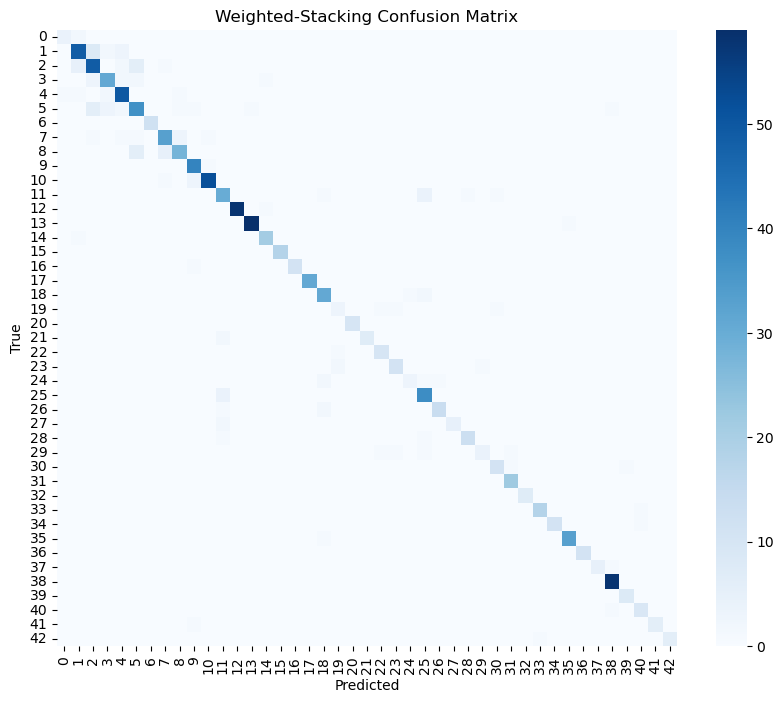

In [48]:
cm = confusion_matrix(y_val, y_val_pred, labels=sorted(np.unique(y_val)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y_val)),
            yticklabels=sorted(np.unique(y_val)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Weighted-Stacking Confusion Matrix")
plt.show()

In [49]:
#Identify the worst‐performing classes (recall < 80%)
report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
low_recall = {cls: stats['recall']
              for cls,stats in report.items() 
              if cls.isdigit() and stats['recall'] < 0.8}
print("Classes with recall < 0.80:")
for cls,rec in sorted(low_recall.items(), key=lambda x: x[1]):
    print(f"  Class {cls}: recall = {rec:.2f}")

Classes with recall < 0.80:
  Class 24: recall = 0.43
  Class 19: recall = 0.50
  Class 29: recall = 0.50
  Class 0: recall = 0.67
  Class 5: recall = 0.71
  Class 27: recall = 0.71
  Class 8: recall = 0.72
  Class 2: recall = 0.78
  Class 21: recall = 0.78
  Class 23: recall = 0.79
  Class 1: recall = 0.79
  Class 3: recall = 0.79


### 3. Wrap in CalibratedClassifierCV

In [92]:
svm_calib = CalibratedClassifierCV(svm_pipe, cv=3, method='sigmoid')
rf_calib  = CalibratedClassifierCV(rf_pipe,  cv=3, method='sigmoid')
mlp_calib = CalibratedClassifierCV(mlp_pipe, cv=3, method='sigmoid')

stack_calib = StackingClassifier(
    estimators=[
      ('rf',  rf_calib),
      ('svm', svm_calib),
      ('mlp', mlp_calib)
    ],
    final_estimator=LogisticRegression(
        class_weight=class_weight_dict, max_iter=2000, solver='saga'
    ),
    cv=5,
    passthrough=True,
    n_jobs=-1
)

stack_calib.fit(X_train, y_train)
y_val_pred2 = stack_calib.predict(X_val)
print("Calibrated ensemble — Acc:", accuracy_score(y_val, y_val_pred2),
      "Macro F1:", f1_score(y_val, y_val_pred2, average='macro'))

C:\Users\trong\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Calibrated ensemble — Acc: 0.8652094717668488 Macro F1: 0.856724465957418


### 4. Tune the meta-learner’s hyperparameters

In [93]:
param_grid = {
  'final_estimator__C':    [0.01, 0.1, 1, 10],
  'final_estimator__penalty': ['l2', 'l1']
}

stack_tuned = GridSearchCV(
    stack_clf_cw, param_grid,
    cv=3, scoring='accuracy', n_jobs=-1, verbose=2
)
stack_tuned.fit(X_train, y_train)
print("Best meta-C & penalty:", stack_tuned.best_params_)
y_val_pred3 = stack_tuned.predict(X_val)
print("Tuned meta — Acc:", accuracy_score(y_val, y_val_pred3),
      "Macro F1:", f1_score(y_val, y_val_pred3, average='macro'))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\trong\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best meta-C & penalty: {'final_estimator__C': 10, 'final_estimator__penalty': 'l2'}
Tuned meta — Acc: 0.8770491803278688 Macro F1: 0.8714547215686274


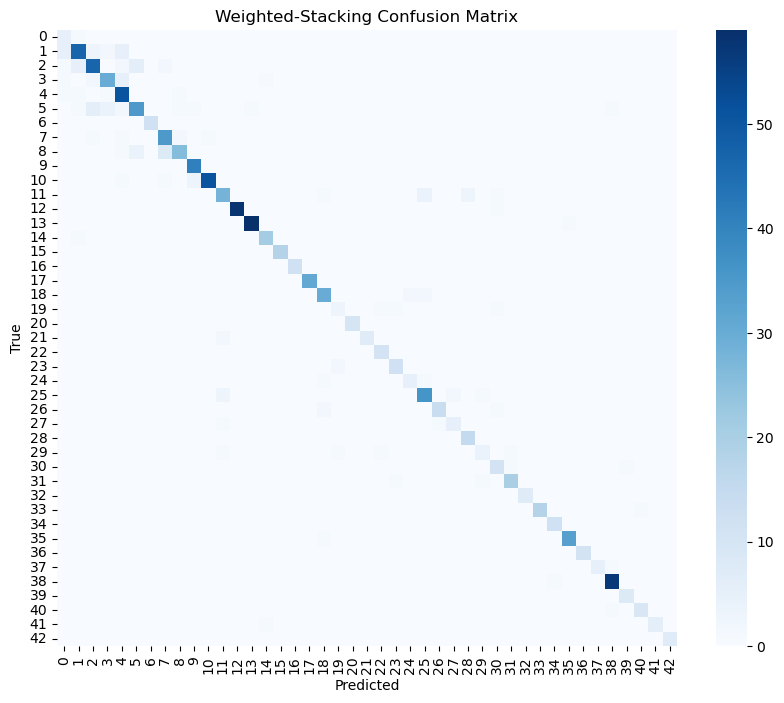

In [95]:
cm = confusion_matrix(y_val, y_val_pred3, labels=sorted(np.unique(y_val)))
plt.figure(figsize=(10,8))
sns.heatmap(cm, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y_val)),
            yticklabels=sorted(np.unique(y_val)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Weighted-Stacking Confusion Matrix")
plt.show()

In [97]:
# Identify the worst‐performing classes (recall < 80%)
report = classification_report(y_val, y_val_pred3, output_dict=True, zero_division=0)
low_recall = {cls: stats['recall']
              for cls,stats in report.items() 
              if cls.isdigit() and stats['recall'] < 0.8}
print("Classes with recall < 0.80:")
for cls,rec in sorted(low_recall.items(), key=lambda x: x[1]):
    print(f"  Class {cls}: recall = {rec:.2f}")

Classes with recall < 0.80:
  Class 19: recall = 0.50
  Class 29: recall = 0.50
  Class 8: recall = 0.67
  Class 5: recall = 0.67
  Class 24: recall = 0.71
  Class 27: recall = 0.71
  Class 2: recall = 0.75
  Class 11: recall = 0.76
  Class 1: recall = 0.76
  Class 3: recall = 0.77
  Class 21: recall = 0.78


### 5. Targeted over sampling of low-recall classes

In [50]:
def oversample_minority_and_train_stack(
    X_train, y_train, 
    low_recall_classes,
    rf_pipe, svm_pipe, mlp_pipe,
    meta_C=10, meta_penalty='l2',
    random_state=18
):
    # Combine into a single DataFrame
    df = X_train.copy()
    df['ClassId'] = y_train.values

    # Determine the maximum class count
    class_counts = df['ClassId'].value_counts()
    max_count = class_counts.max()

    # Collect resampled DataFrames
    frames = [df]
    for cls in low_recall_classes:
        cls_df = df[df['ClassId'] == cls]
        n_samples = max_count - len(cls_df)
        if n_samples > 0:
            # Upsample by random resampling with replacement
            upsampled = resample(
                cls_df,
                replace=True,
                n_samples=n_samples,
                random_state=random_state
            )
            frames.append(upsampled)

    # Concatenate all and shuffle
    df_resampled = pd.concat(frames)
    df_resampled = df_resampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Split back
    y_res = df_resampled['ClassId']
    X_res = df_resampled.drop(columns=['ClassId'])

    # Build stacking classifier with weighted meta-learner
    stack = StackingClassifier(
        estimators=[('rf', rf_pipe), ('svm', svm_pipe), ('mlp', mlp_pipe)],
        final_estimator=LogisticRegression(
            C=meta_C,
            penalty=meta_penalty,
            solver='lbfgs',
            max_iter=5000,
            random_state=random_state
        ),
        cv=5,
        n_jobs=-1,
        passthrough=True
    )

    # Fit on the oversampled training data
    stack.fit(X_res, y_res)
    return stack


low_recall = [24, 19, 29, 0, 5, 27, 8, 2, 21, 23, 1, 3]

stack_df_res = oversample_minority_and_train_stack(
    X_train, y_train, low_recall,
    rf_pipe, svm_pipe, mlp_pipe,
    meta_C=10, meta_penalty='l2',
    random_state=18
)

# Evaluate on validation set
y_val_pred_res = stack_df_res.predict(X_val)
acc_res = accuracy_score(y_val, y_val_pred_res)
f1_res  = f1_score(y_val, y_val_pred_res, average='macro')

results = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro F1'],
    'Score': [acc_res, f1_res]
}).set_index('Metric')


C:\Users\trong\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
print(results)

             Score
Metric            
Accuracy  0.876138
Macro F1  0.870474


## Predict test labels

In [26]:
# List of low-recall classes 
low_recall = [29, 24, 19, 0, 8, 3, 5, 27, 2, 26, 21]

# Build a class_weight dict that doubles the penalty for those classes:
classes = np.unique(y_train)
cw = {int(c): (2.0 if c in low_recall else 1.0) for c in classes}

# Rebuild the stacking classifier with a class‐weighted final estimator:
stack_clf_weighted = StackingClassifier(
    estimators=[
        ('rf',  rf_pipe),
        ('svm', svm_pipe),
        ('mlp', mlp_pipe)
    ],
    final_estimator=LogisticRegression(
        class_weight=cw,
        solver='lbfgs',
        max_iter=3000
    ),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Fit on the training split
stack_clf_weighted.fit(X_full, y_full)

# Predict & evaluate on validation
y_test_pred = stack_clf_weighted.predict(X_test)
generate_submission("stack.csv", test_id, y_test_pred)

C:\Users\trong\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


First 5 rows of the submission:
     id  ClassId
0   661       12
1  4477        2
2  1046        2
3   631        7
4  6533        5


# 3.5 CNN (Convolutional Neural Network)

In [51]:
# Parameters
IMAGE_SIZE  = (32, 32)
BATCH_SIZE  = 64
NUM_CLASSES = 43
EPOCHS      = 30
SEED        = 18
train_meta['ClassId'] = train_meta['ClassId'].astype(str)

# Build generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    channel_shift_range=20.0,
    brightness_range=(0.7,1.3),
    fill_mode='nearest'
)

train_gen = datagen.flow_from_dataframe(
    dataframe = train_meta,
    directory = '2025_A2/train/',
    x_col     = 'image_path',
    y_col     = 'ClassId',      
    target_size = IMAGE_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'sparse',
    subset      = 'training',
    seed        = SEED
)

val_gen = datagen.flow_from_dataframe(
    dataframe = train_meta,
    directory = '2025_A2/train/',
    x_col     = 'image_path',
    y_col     = 'ClassId',
    target_size = IMAGE_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'sparse',
    subset      = 'validation',
    seed        = SEED
)

Found 4391 validated image filenames belonging to 43 classes.
Found 1097 validated image filenames belonging to 43 classes.


## 3.5.1 Small CNN

In [52]:
# Define a small CNN
def make_small_cnn(input_shape=(32,32,3), num_classes=NUM_CLASSES):
    inp = layers.Input(shape=input_shape)
    x   = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x   = layers.MaxPooling2D(2)(x)
    x   = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x   = layers.MaxPooling2D(2)(x)
    x   = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x   = layers.MaxPooling2D(2)(x)
    x   = layers.Flatten()(x)
    x   = layers.Dense(128, activation='relu')(x)
    x   = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inp, out)

cnn = make_small_cnn()

# Compile with sparse loss
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

# Train with early stopping
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True
)

history = cnn.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[es],
    verbose=2
)

# Evaluate on validation
val_loss, val_acc = cnn.evaluate(val_gen, verbose=0)
print(f"CNN Validation Accuracy: {val_acc:.4f}")

Epoch 1/30
69/69 - 6s - loss: 3.5938 - accuracy: 0.0594 - val_loss: 3.4259 - val_accuracy: 0.1021 - 6s/epoch - 89ms/step
Epoch 2/30
69/69 - 5s - loss: 3.3836 - accuracy: 0.1023 - val_loss: 3.1931 - val_accuracy: 0.1459 - 5s/epoch - 72ms/step
Epoch 3/30
69/69 - 5s - loss: 3.1365 - accuracy: 0.1533 - val_loss: 2.9026 - val_accuracy: 0.1869 - 5s/epoch - 72ms/step
Epoch 4/30
69/69 - 5s - loss: 2.9222 - accuracy: 0.1870 - val_loss: 2.6197 - val_accuracy: 0.2744 - 5s/epoch - 72ms/step
Epoch 5/30
69/69 - 5s - loss: 2.6865 - accuracy: 0.2487 - val_loss: 2.3661 - val_accuracy: 0.3327 - 5s/epoch - 72ms/step
Epoch 6/30
69/69 - 5s - loss: 2.4800 - accuracy: 0.2847 - val_loss: 2.1941 - val_accuracy: 0.3601 - 5s/epoch - 74ms/step
Epoch 7/30
69/69 - 5s - loss: 2.2830 - accuracy: 0.3193 - val_loss: 2.0296 - val_accuracy: 0.3810 - 5s/epoch - 72ms/step
Epoch 8/30
69/69 - 5s - loss: 2.1611 - accuracy: 0.3507 - val_loss: 1.8980 - val_accuracy: 0.4275 - 5s/epoch - 71ms/step
Epoch 9/30
69/69 - 5s - loss: 2.

### Evaluation for small CNN

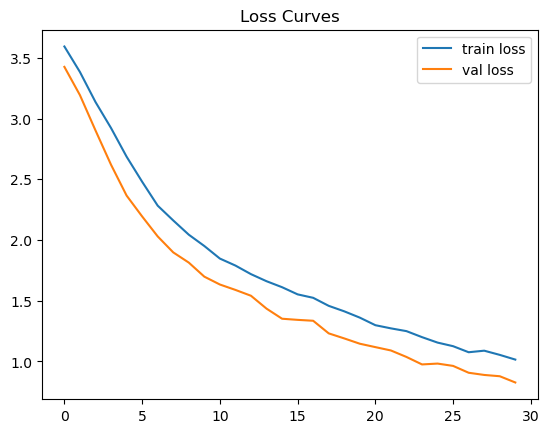

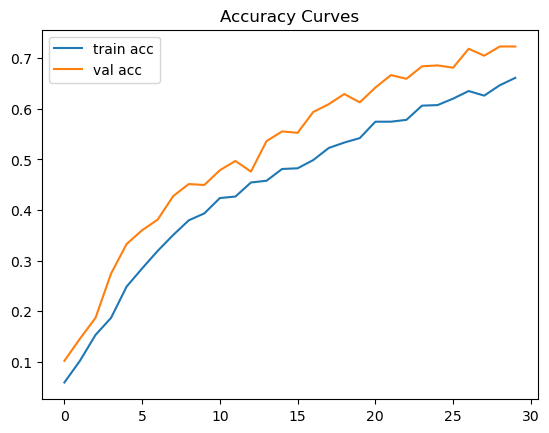

In [54]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy Curves")
plt.show()

## 3.5.2 Fine-tune CNN

In [55]:
train_meta['ClassId'] = train_meta['ClassId'].astype(str)

# Generators with strong augmentation
IMAGE_SIZE = (32, 32)
BATCH_SIZE = 64
SEED       = 18

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    channel_shift_range=20.0,
    brightness_range=(0.7,1.3),
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_meta,
    directory='2025_A2/train/',
    x_col='image_path',
    y_col='ClassId',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    subset='training',
    seed=SEED
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_meta,
    directory='2025_A2/train/',
    x_col='image_path',
    y_col='ClassId',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

# Model definition 
def make_cnn_bn(input_shape=(32,32,3), num_classes=43):
    inp = layers.Input(shape=input_shape)
    x   = layers.Conv2D(32,3,padding='same')(inp)
    x   = layers.BatchNormalization()(x)
    x   = layers.Activation('relu')(x)
    x   = layers.MaxPooling2D(2)(x)

    x   = layers.Conv2D(64,3,padding='same')(x)
    x   = layers.BatchNormalization()(x)
    x   = layers.Activation('relu')(x)
    x   = layers.MaxPooling2D(2)(x)

    x   = layers.Conv2D(128,3,padding='same')(x)
    x   = layers.BatchNormalization()(x)
    x   = layers.Activation('relu')(x)
    x   = layers.MaxPooling2D(2)(x)

    x   = layers.Conv2D(256,3,padding='same')(x)
    x   = layers.BatchNormalization()(x)
    x   = layers.Activation('relu')(x)
    x   = layers.MaxPooling2D(2)(x)

    x   = layers.Flatten()(x)
    x   = layers.Dense(256)(x)
    x   = layers.BatchNormalization()(x)
    x   = layers.Activation('relu')(x)
    x   = layers.Dropout(0.5)(x)

    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inp, out)

cnn = make_cnn_bn()

# Compile with categorical loss
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
]

# Train
history = cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    verbose=2
)

val_loss, val_acc = cnn.evaluate(val_gen, verbose=0)
print(f"Improved CNN Validation Accuracy: {val_acc:.4f}")

Found 4391 validated image filenames belonging to 43 classes.
Found 1097 validated image filenames belonging to 43 classes.
Epoch 1/50
69/69 - 7s - loss: 3.5010 - accuracy: 0.1255 - val_loss: 3.5473 - val_accuracy: 0.0793 - lr: 0.0010 - 7s/epoch - 103ms/step
Epoch 2/50
69/69 - 6s - loss: 2.4945 - accuracy: 0.3084 - val_loss: 3.8341 - val_accuracy: 0.0975 - lr: 0.0010 - 6s/epoch - 80ms/step
Epoch 3/50
69/69 - 5s - loss: 1.9618 - accuracy: 0.4275 - val_loss: 3.8738 - val_accuracy: 0.0811 - lr: 0.0010 - 5s/epoch - 80ms/step
Epoch 4/50
69/69 - 6s - loss: 1.6664 - accuracy: 0.4981 - val_loss: 3.0193 - val_accuracy: 0.2434 - lr: 0.0010 - 6s/epoch - 80ms/step
Epoch 5/50
69/69 - 6s - loss: 1.4207 - accuracy: 0.5714 - val_loss: 2.2709 - val_accuracy: 0.3318 - lr: 0.0010 - 6s/epoch - 80ms/step
Epoch 6/50
69/69 - 5s - loss: 1.1938 - accuracy: 0.6370 - val_loss: 2.1562 - val_accuracy: 0.3774 - lr: 0.0010 - 5s/epoch - 79ms/step
Epoch 7/50
69/69 - 6s - loss: 1.0631 - accuracy: 0.6787 - val_loss: 1.6

### Evaluate on tuned CNN

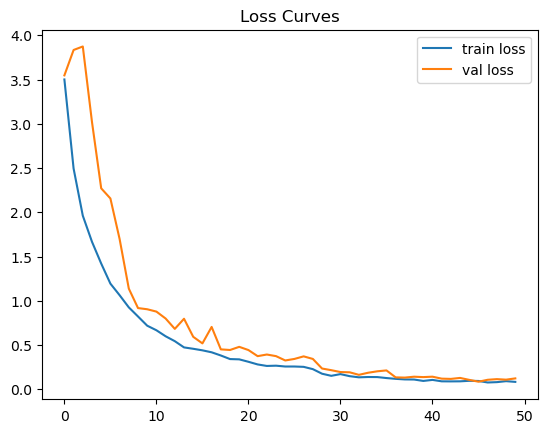

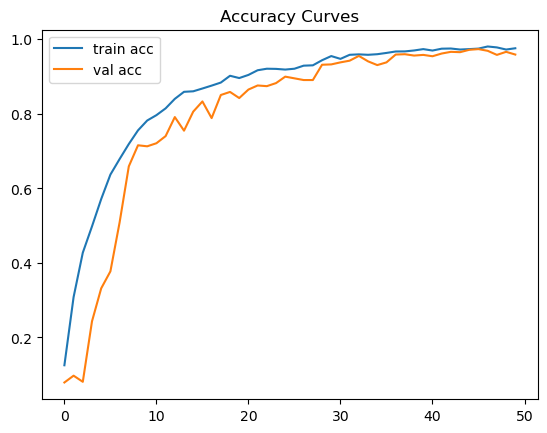

In [56]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy Curves")
plt.show()

### Sign of underfitting, increase model capacity

In [58]:
# Build a slightly deeper CNN with a small residual block and wider dense layer
def make_residual_cnn(input_shape=(32,32,3), num_classes=43, dropout_rate=0.5):
    inp = layers.Input(shape=input_shape)
    
    # Initial conv stack
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    # Residual block at 128 channels
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # skip connection
    shortcut = layers.Conv2D(128, 1, padding='same')(inp if x.shape[1:] == inp.shape[1:] else x)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Extra conv block at 256 channels
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    # Classification head
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)      
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inp, outputs=out)

# Instantiate the model
cnn_res = make_residual_cnn(input_shape=(*IMAGE_SIZE, 3), num_classes=NUM_CLASSES, dropout_rate=0.5)

# Compile with sparse loss and a small learning rate
cnn_res.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

# Callbacks 
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Train for up to 80 epochs
history_res = cnn_res.fit(
    train_gen,
    validation_data=val_gen,
    epochs=80,
    callbacks=callbacks,
    verbose=2
)

# Evaluate on validation
val_loss, val_acc = cnn_res.evaluate(val_gen, verbose=0)
print(f"Residual CNN Validation Accuracy: {val_acc:.4f}")

Epoch 1/80
69/69 - 8s - loss: 3.9089 - accuracy: 0.1189 - val_loss: 3.6938 - val_accuracy: 0.0419 - lr: 0.0010 - 8s/epoch - 121ms/step
Epoch 2/80
69/69 - 6s - loss: 2.9235 - accuracy: 0.2610 - val_loss: 3.6573 - val_accuracy: 0.0738 - lr: 0.0010 - 6s/epoch - 88ms/step
Epoch 3/80
69/69 - 6s - loss: 2.1291 - accuracy: 0.3933 - val_loss: 4.0526 - val_accuracy: 0.0912 - lr: 0.0010 - 6s/epoch - 89ms/step
Epoch 4/80
69/69 - 6s - loss: 1.6540 - accuracy: 0.4933 - val_loss: 4.2530 - val_accuracy: 0.0893 - lr: 0.0010 - 6s/epoch - 93ms/step
Epoch 5/80
69/69 - 6s - loss: 1.3097 - accuracy: 0.5919 - val_loss: 3.0836 - val_accuracy: 0.2151 - lr: 0.0010 - 6s/epoch - 89ms/step
Epoch 6/80
69/69 - 6s - loss: 1.0226 - accuracy: 0.6796 - val_loss: 2.5948 - val_accuracy: 0.2853 - lr: 0.0010 - 6s/epoch - 90ms/step
Epoch 7/80
69/69 - 6s - loss: 0.8375 - accuracy: 0.7381 - val_loss: 1.7632 - val_accuracy: 0.4567 - lr: 0.0010 - 6s/epoch - 87ms/step
Epoch 8/80
69/69 - 6s - loss: 0.7296 - accuracy: 0.7727 - val

### Regularized CNN with cosine‐decay schedule

In [62]:
# Build a CNN with L2 regularization and reduced dropout
def make_cnn_reg(input_shape=(32,32,3), num_classes=43, dropout_rate=0.3, weight_decay=1e-4):
    inp = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

 
    x = layers.Conv2D(128, 3, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)


    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(weight_decay))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=regularizers.l2(weight_decay))(x)

    return models.Model(inputs=inp, outputs=out)

# Instantiate the model
cnn_reg = make_cnn_reg(
    input_shape=(*IMAGE_SIZE, 3),
    num_classes=NUM_CLASSES,
    dropout_rate=0.3,
    weight_decay=1e-4
)

# Create a cosine decay schedule
steps_per_epoch = len(train_gen)
total_steps = EPOCHS * steps_per_epoch
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=total_steps,
    alpha=1e-5 / 1e-3  # final lr = 1e-5
)

# Compile with the cosine schedule
cnn_reg.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train
history_reg = cnn_reg.fit(
    train_gen,
    validation_data=val_gen,
    epochs= 80,
    callbacks=[es],
    verbose=2
)

# Evaluate
val_loss, val_acc = cnn_reg.evaluate(val_gen, verbose=0)
print(f"Regularized CNN Validation Accuracy: {val_acc:.4f}")

Epoch 1/80
69/69 - 7s - loss: 3.5518 - accuracy: 0.1831 - val_loss: 3.9996 - val_accuracy: 0.0428 - 7s/epoch - 103ms/step
Epoch 2/80
69/69 - 6s - loss: 2.3702 - accuracy: 0.3790 - val_loss: 4.6021 - val_accuracy: 0.0428 - 6s/epoch - 80ms/step
Epoch 3/80
69/69 - 5s - loss: 1.7859 - accuracy: 0.5028 - val_loss: 5.0181 - val_accuracy: 0.0775 - 5s/epoch - 80ms/step
Epoch 4/80
69/69 - 5s - loss: 1.4664 - accuracy: 0.5885 - val_loss: 5.0240 - val_accuracy: 0.0884 - 5s/epoch - 80ms/step
Epoch 5/80
69/69 - 6s - loss: 1.1960 - accuracy: 0.6629 - val_loss: 3.7427 - val_accuracy: 0.1796 - 6s/epoch - 80ms/step
Epoch 6/80
69/69 - 5s - loss: 0.9755 - accuracy: 0.7329 - val_loss: 2.4886 - val_accuracy: 0.3856 - 5s/epoch - 79ms/step
Epoch 7/80
69/69 - 6s - loss: 0.8157 - accuracy: 0.7862 - val_loss: 1.8123 - val_accuracy: 0.4768 - 6s/epoch - 80ms/step
Epoch 8/80
69/69 - 6s - loss: 0.7146 - accuracy: 0.8205 - val_loss: 1.0448 - val_accuracy: 0.7001 - 6s/epoch - 87ms/step
Epoch 9/80
69/69 - 6s - loss: 0

## No improvement, back to old model with greater epochs

In [69]:
# Model from above
def make_residual_cnn(input_shape=(32,32,3), num_classes=43, dropout_rate=0.5):
    inp = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # skip connection
    shortcut = layers.Conv2D(128, 1, padding='same')(inp if x.shape[1:] == inp.shape[1:] else x)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)


    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    # Classification head
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)       
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inp, outputs=out)

# Instantiate the model
cnn_res = make_residual_cnn(input_shape=(*IMAGE_SIZE, 3), num_classes=NUM_CLASSES, dropout_rate=0.5)

# Compile with sparse loss and a small learning rate
cnn_res.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',   # <— match one-hot
    metrics=['accuracy']
)

# Callbacks 
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Train for up to 80 epochs
history_res = cnn_res.fit(
    train_gen,
    validation_data=val_gen,
    epochs=80,
    callbacks=callbacks,
    verbose=2
)

# Evaluate on validation set
val_loss, val_acc = cnn_res.evaluate(val_gen, verbose=0)
print(f"Residual CNN Validation Accuracy: {val_acc:.4f}")

Epoch 1/80
69/69 - 9s - loss: 3.7759 - accuracy: 0.1437 - val_loss: 3.8963 - val_accuracy: 0.0483 - lr: 0.0010 - 9s/epoch - 127ms/step
Epoch 2/80
69/69 - 7s - loss: 2.7329 - accuracy: 0.2717 - val_loss: 3.8087 - val_accuracy: 0.0848 - lr: 0.0010 - 7s/epoch - 99ms/step
Epoch 3/80
69/69 - 6s - loss: 2.1291 - accuracy: 0.3972 - val_loss: 4.2019 - val_accuracy: 0.0757 - lr: 0.0010 - 6s/epoch - 93ms/step
Epoch 4/80
69/69 - 6s - loss: 1.6934 - accuracy: 0.4871 - val_loss: 4.2856 - val_accuracy: 0.1039 - lr: 0.0010 - 6s/epoch - 91ms/step
Epoch 5/80
69/69 - 6s - loss: 1.4160 - accuracy: 0.5621 - val_loss: 3.2406 - val_accuracy: 0.1942 - lr: 0.0010 - 6s/epoch - 89ms/step
Epoch 6/80
69/69 - 6s - loss: 1.1190 - accuracy: 0.6563 - val_loss: 2.1119 - val_accuracy: 0.3820 - lr: 0.0010 - 6s/epoch - 89ms/step
Epoch 7/80
69/69 - 6s - loss: 0.9296 - accuracy: 0.7051 - val_loss: 1.5166 - val_accuracy: 0.5077 - lr: 0.0010 - 6s/epoch - 90ms/step
Epoch 8/80
69/69 - 6s - loss: 0.8119 - accuracy: 0.7358 - val

Epoch 60/80
69/69 - 6s - loss: 0.0363 - accuracy: 0.9888 - val_loss: 0.0902 - val_accuracy: 0.9699 - lr: 1.2500e-04 - 6s/epoch - 93ms/step
Epoch 61/80

Epoch 61: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
69/69 - 6s - loss: 0.0395 - accuracy: 0.9870 - val_loss: 0.0946 - val_accuracy: 0.9672 - lr: 1.2500e-04 - 6s/epoch - 91ms/step
Epoch 62/80
69/69 - 6s - loss: 0.0398 - accuracy: 0.9895 - val_loss: 0.0802 - val_accuracy: 0.9754 - lr: 6.2500e-05 - 6s/epoch - 92ms/step
Epoch 63/80
69/69 - 6s - loss: 0.0336 - accuracy: 0.9882 - val_loss: 0.0803 - val_accuracy: 0.9745 - lr: 6.2500e-05 - 6s/epoch - 93ms/step
Epoch 64/80
69/69 - 6s - loss: 0.0406 - accuracy: 0.9861 - val_loss: 0.0725 - val_accuracy: 0.9754 - lr: 6.2500e-05 - 6s/epoch - 93ms/step
Epoch 65/80
69/69 - 6s - loss: 0.0392 - accuracy: 0.9900 - val_loss: 0.0765 - val_accuracy: 0.9727 - lr: 6.2500e-05 - 6s/epoch - 91ms/step
Residual CNN Validation Accuracy: 0.9727


In [71]:
# Full-train generator with augmentation
full_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    channel_shift_range=20.0,
    brightness_range=(0.7,1.3),
    fill_mode='nearest'
)

full_train_gen = full_datagen.flow_from_dataframe(
    dataframe=train_meta,             
    directory='2025_A2/train/',
    x_col='image_path',
    y_col='ClassId',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',        
    shuffle=True,
    seed=SEED
)

# Retrain the residual CNN on all data
history_full = cnn_res.fit(
    full_train_gen,
    epochs=55,                        
    verbose=2
)

# Prepare test generator 
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_meta,
    directory='2025_A2/test/',
    x_col='image_path',
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Predict on test set
probs = cnn_res.predict(test_gen, verbose=1)
y_idx = probs.argmax(axis=1).astype(int)
print(y_idx)

Found 5488 validated image filenames belonging to 43 classes.
Epoch 1/55
86/86 - 6s - loss: 0.0454 - accuracy: 0.9862 - 6s/epoch - 73ms/step
Epoch 2/55
86/86 - 6s - loss: 0.0487 - accuracy: 0.9867 - 6s/epoch - 74ms/step
Epoch 3/55
86/86 - 6s - loss: 0.0453 - accuracy: 0.9854 - 6s/epoch - 73ms/step
Epoch 4/55
86/86 - 6s - loss: 0.0406 - accuracy: 0.9882 - 6s/epoch - 72ms/step
Epoch 5/55
86/86 - 6s - loss: 0.0380 - accuracy: 0.9891 - 6s/epoch - 73ms/step
Epoch 6/55
86/86 - 6s - loss: 0.0485 - accuracy: 0.9858 - 6s/epoch - 73ms/step
Epoch 7/55
86/86 - 7s - loss: 0.0469 - accuracy: 0.9863 - 7s/epoch - 78ms/step
Epoch 8/55
86/86 - 6s - loss: 0.0400 - accuracy: 0.9891 - 6s/epoch - 76ms/step
Epoch 9/55
86/86 - 6s - loss: 0.0462 - accuracy: 0.9849 - 6s/epoch - 74ms/step
Epoch 10/55
86/86 - 6s - loss: 0.0475 - accuracy: 0.9858 - 6s/epoch - 75ms/step
Epoch 11/55
86/86 - 6s - loss: 0.0427 - accuracy: 0.9883 - 6s/epoch - 74ms/step
Epoch 12/55
86/86 - 7s - loss: 0.0499 - accuracy: 0.9832 - 7s/epoch

In [73]:
inv_map = {v: int(k) for k, v in train_gen.class_indices.items()}
y_pred_labels = [inv_map[idx] for idx in y_idx]
generate_submission("tuned_cnn.csv", test_id, y_pred_labels)

First 5 rows of the submission:
     id  ClassId
0   661       12
1  4477       16
2  1046       39
3   631        2
4  6533        3


## 3.5.3 Final CNN Model

### Upscale image to (96 x 96)

In [33]:
# Parameters
IMAGE_SIZE  = (96, 96)
BATCH_SIZE  = 64
NUM_CLASSES = 43
EPOCHS      = 30
SEED        = 18

train_meta['ClassId'] = train_meta['ClassId'].astype(str)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    channel_shift_range=20.0,
    brightness_range=(0.7,1.3),
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_meta,
    directory='2025_A2/train/',
    x_col='image_path',
    y_col='ClassId',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # one-hot
    subset='training',
    seed=SEED
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_meta,
    directory='2025_A2/train/',
    x_col='image_path',
    y_col='ClassId',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED
)

Found 4391 validated image filenames belonging to 43 classes.
Found 1097 validated image filenames belonging to 43 classes.


In [34]:
# Build a deeper CNN with a small residual block and wider dense layer
def make_residual_cnn(input_shape=(96,96,3), num_classes=43, dropout_rate=0.5):
    inp = layers.Input(shape=input_shape)
    
    # Initial conv stack
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    # Residual block at 128 channels
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # skip connection
    shortcut = layers.Conv2D(128, 1, padding='same')(inp if x.shape[1:] == inp.shape[1:] else x)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Extra conv block at 256 channels
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    # Classification head
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)         # increased width
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inp, outputs=out)

# Instantiate the model
cnn_res = make_residual_cnn(input_shape=(96, 96, 3), num_classes=NUM_CLASSES, dropout_rate=0.5)

# Compile with sparse loss and a small learning rate
cnn_res.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',   # <— match one-hot
    metrics=['accuracy']
)

# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

# Train for up to 80 epochs
history_res = cnn_res.fit(
    train_gen,
    validation_data=val_gen,
    epochs=80,
    callbacks=callbacks,
    verbose=2
)

# Evaluate on validation
val_loss, val_acc = cnn_res.evaluate(val_gen, verbose=0)
print(f"Residual CNN Validation Accuracy: {val_acc:.4f}")



Epoch 1/80


69/69 - 33s - loss: 3.7994 - accuracy: 0.1546 - val_loss: 3.8472 - val_accuracy: 0.0684 - lr: 0.0010 - 33s/epoch - 483ms/step
Epoch 2/80
69/69 - 30s - loss: 2.8326 - accuracy: 0.2842 - val_loss: 3.8995 - val_accuracy: 0.0629 - lr: 0.0010 - 30s/epoch - 431ms/step
Epoch 3/80
69/69 - 29s - loss: 2.0099 - accuracy: 0.4245 - val_loss: 7.2664 - val_accuracy: 0.0638 - lr: 0.0010 - 29s/epoch - 420ms/step
Epoch 4/80
69/69 - 29s - loss: 1.7091 - accuracy: 0.5069 - val_loss: 3.6602 - val_accuracy: 0.1194 - lr: 0.0010 - 29s/epoch - 426ms/step
Epoch 5/80
69/69 - 29s - loss: 1.1892 - accuracy: 0.6258 - val_loss: 2.7549 - val_accuracy: 0.2689 - lr: 0.0010 - 29s/epoch - 426ms/step
Epoch 6/80
69/69 - 29s - loss: 0.8982 - accuracy: 0.7203 - val_loss: 2.1412 - val_accuracy: 0.3938 - lr: 0.0010 - 29s/epoch - 426ms/step
Epoch 7/80
69/69 - 29s - loss: 0.6415 - accuracy: 0.7982 - val_loss: 1.3181 - val_accuracy: 0.6171 - lr: 0.0010 - 29s/epoch - 414ms/step
Epoch 8/80
69/69 - 28s - loss: 0.4770

Epoch 53/80
69/69 - 26s - loss: 0.0244 - accuracy: 0.9927 - val_loss: 0.0665 - val_accuracy: 0.9781 - lr: 2.5000e-04 - 26s/epoch - 382ms/step
Epoch 54/80
69/69 - 27s - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0558 - val_accuracy: 0.9845 - lr: 2.5000e-04 - 27s/epoch - 386ms/step
Epoch 55/80
69/69 - 27s - loss: 0.0262 - accuracy: 0.9929 - val_loss: 0.0463 - val_accuracy: 0.9827 - lr: 2.5000e-04 - 27s/epoch - 389ms/step
Epoch 56/80
69/69 - 27s - loss: 0.0230 - accuracy: 0.9929 - val_loss: 0.0355 - val_accuracy: 0.9872 - lr: 2.5000e-04 - 27s/epoch - 393ms/step
Epoch 57/80
69/69 - 27s - loss: 0.0174 - accuracy: 0.9961 - val_loss: 0.0550 - val_accuracy: 0.9836 - lr: 2.5000e-04 - 27s/epoch - 385ms/step
Epoch 58/80
69/69 - 26s - loss: 0.0252 - accuracy: 0.9918 - val_loss: 0.0332 - val_accuracy: 0.9900 - lr: 2.5000e-04 - 26s/epoch - 376ms/step
Epoch 59/80
69/69 - 26s - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.0216 - val_accuracy: 0.9954 - lr: 2.5000e-04 - 26s/epoch - 372ms/step
Epoch 

##  Predict Test labels

In [109]:
# Full-train generator with augmentation 
full_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    channel_shift_range=20.0,
    brightness_range=(0.7,1.3),
    fill_mode='nearest'
)

full_train_gen = full_datagen.flow_from_dataframe(
    dataframe=train_meta,           
    directory='2025_A2/train/',
    x_col='image_path',
    y_col='ClassId',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',       
    shuffle=True,
    seed=SEED
)


history_full = cnn_res.fit(
    full_train_gen,
    epochs=38,                    
    verbose=2
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_meta,
    directory='2025_A2/test/',
    x_col='image_path',
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Predict on test set
probs = cnn_res.predict(test_gen, verbose=1)
y_idx = probs.argmax(axis=1).astype(int)
print(y_idx)

Found 5488 validated image filenames belonging to 43 classes.
Epoch 1/38
86/86 - 27s - loss: 0.0528 - accuracy: 0.9852 - 27s/epoch - 319ms/step
Epoch 2/38
86/86 - 29s - loss: 0.0440 - accuracy: 0.9867 - 29s/epoch - 334ms/step
Epoch 3/38
86/86 - 30s - loss: 0.0465 - accuracy: 0.9883 - 30s/epoch - 354ms/step
Epoch 4/38
86/86 - 29s - loss: 0.0450 - accuracy: 0.9883 - 29s/epoch - 341ms/step
Epoch 5/38
86/86 - 30s - loss: 0.0437 - accuracy: 0.9872 - 30s/epoch - 348ms/step
Epoch 6/38
86/86 - 30s - loss: 0.0431 - accuracy: 0.9885 - 30s/epoch - 354ms/step
Epoch 7/38
86/86 - 30s - loss: 0.0389 - accuracy: 0.9894 - 30s/epoch - 353ms/step
Epoch 8/38
86/86 - 31s - loss: 0.0374 - accuracy: 0.9903 - 31s/epoch - 355ms/step
Epoch 9/38
86/86 - 30s - loss: 0.0375 - accuracy: 0.9889 - 30s/epoch - 354ms/step
Epoch 10/38
86/86 - 30s - loss: 0.0400 - accuracy: 0.9892 - 30s/epoch - 347ms/step
Epoch 11/38
86/86 - 30s - loss: 0.0420 - accuracy: 0.9878 - 30s/epoch - 355ms/step
Epoch 12/38
86/86 - 30s - loss: 0.

In [110]:
inv_map = {v: int(k) for k, v in train_gen.class_indices.items()}
y_pred_labels = [inv_map[idx] for idx in y_idx]
generate_submission("submission.csv", test_id, y_pred_labels)

First 5 rows of the submission:
     id  ClassId
0   661       12
1  4477       16
2  1046       39
3   631        2
4  6533        3


# END.